In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

In [48]:
html_data = pd.read_csv('../data/webpage_metadata.csv')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3269: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Contents

1. [Load & Clean Data](#1.-Load-data)
2. [How old are companies when we first see their website?](#2.-How-old-are-companies-when-we-first-see-their-website?)
3. [Average number of links throughout company life-span](#3.-Average-number-of-links-throughout-company-life-span)
    1. [2019 Example](#3.1-2019-Example)
    2. [1999 Example](#3.2-1999-Example)
4. [Webpage size](#4.-Webpage-size-time-series)
    1. [Over year captured](#4.1-Website-size-over-year-captured-(capture_yr)
    2. [For companies with >= 5 year lifespan](#4.2-For-companies-that-have-been-around-for-at-least-5-years?)
    3. [For companies with >= 10 year lifespan](#4.3-10+-years?)
    4. [For companies with first timestamp within 0-2 years of the founding date](#4.4-For-companies-that-got-their-first-their-first-timestamp-within-0-2-years-of-the-founding-date?)
5. [Meta Tags](#5.-Meta-tag-time-series)
    1. [Description](#5.1-Description)
    2. [Keywords](#5.2-Keywords)
    3. [Description over capture year](#5.3-Description-Over-Capture-Year)
    4. [Keywords over capture year](#5.4-Keywords-Over-Capture-Year)
6. [Career/Job Posting Links](#6.-Does-<a>'s-innertext-include-the-words-"job"-or-"careers")
    1. [For companies with first timestamp within 0-2 years of the founding date](#6.1-For-companies-that-got-their-first-their-first-timestamp-within-0-2-years-of-the-founding-date?)
    1. [Over year captured](#6.2-Over-year-captured?)
    2. [Companies founded after 2010](#6.3-Companies-founded-after-2010?)


## 1. Load data

In [49]:
html_data.head()

,entityid,domain,founded_yr,capture_yr,capture_m,time_from_start_m,website_size_kb,title,num_a_tags,a_innertext,meta_description,meta_keywords,pb_companyid,startdate,ownershipstatus,exit_date
0,1001099837,www.related.com,1972,2001,11,358.0,4.750977,Untitled Document,7,"['Park Imperial Condominiums', 'Related Rental...",0,0,NaN,1972-01-01,Private & Independent,NaN
1,1001099837,www.related.com,1972,2008,8,439.0,20.040039,Related Home Page,10,"['Search Help', 'About section', 'view article']",0,0,NaN,1972-01-01,Private & Independent,NaN
2,1001099837,www.related.com,1972,2010,7,462.0,29.330078,"\n\tRelated Real Estate, Apartments For Rent &...",16,"['Forgot Password?', 'here', 'NEWS & PRESS', '...",1,1,NaN,1972-01-01,Private & Independent,NaN
3,1001099837,www.related.com,1972,2011,1,468.0,30.825195,"\n\tRelated Real Estate, Apartments For Rent &...",17,"['Forgot Password?', 'here', 'NEWS & PRESS', '...",1,1,NaN,1972-01-01,Private & Independent,NaN
4,1001099837,www.related.com,1972,2011,7,474.0,30.673828,"\n\tRelated Real Estate, Apartments For Rent &...",16,"['Forgot Password?', 'NEWS & PRESS', 'CAREERS'...",1,1,NaN,1972-01-01,Private & Independent,NaN


First, let's look at how old some of these companies are, so our data doesn't look skewed. What's the oldest company?

In [50]:
html_data[html_data.time_from_start_m == html_data.time_from_start_m.max()]

,entityid,domain,founded_yr,capture_yr,capture_m,time_from_start_m,website_size_kb,title,num_a_tags,a_innertext,meta_description,meta_keywords,pb_companyid,startdate,ownershipstatus,exit_date
101174,1047067805,www.apexorchards.com,1827,2023,5,2345.0,48.238281,HOME | Apex Orchards,36,"['Apex Orchards', 'HOME', 'ABOUT', 'ABOUT', 'H...",0,0,NaN,1827-12-30,Private & Independent,NaN


Also, let's convert our `time_from_start_m` statistic into a yearly unit named `tfs_y`, rounding to the nearest half-year

In [51]:
html_data["tfs_y"] = round((html_data.time_from_start_m / 12) * 2) / 2

If we look at the distribution, we see the long tail of data from older companies.

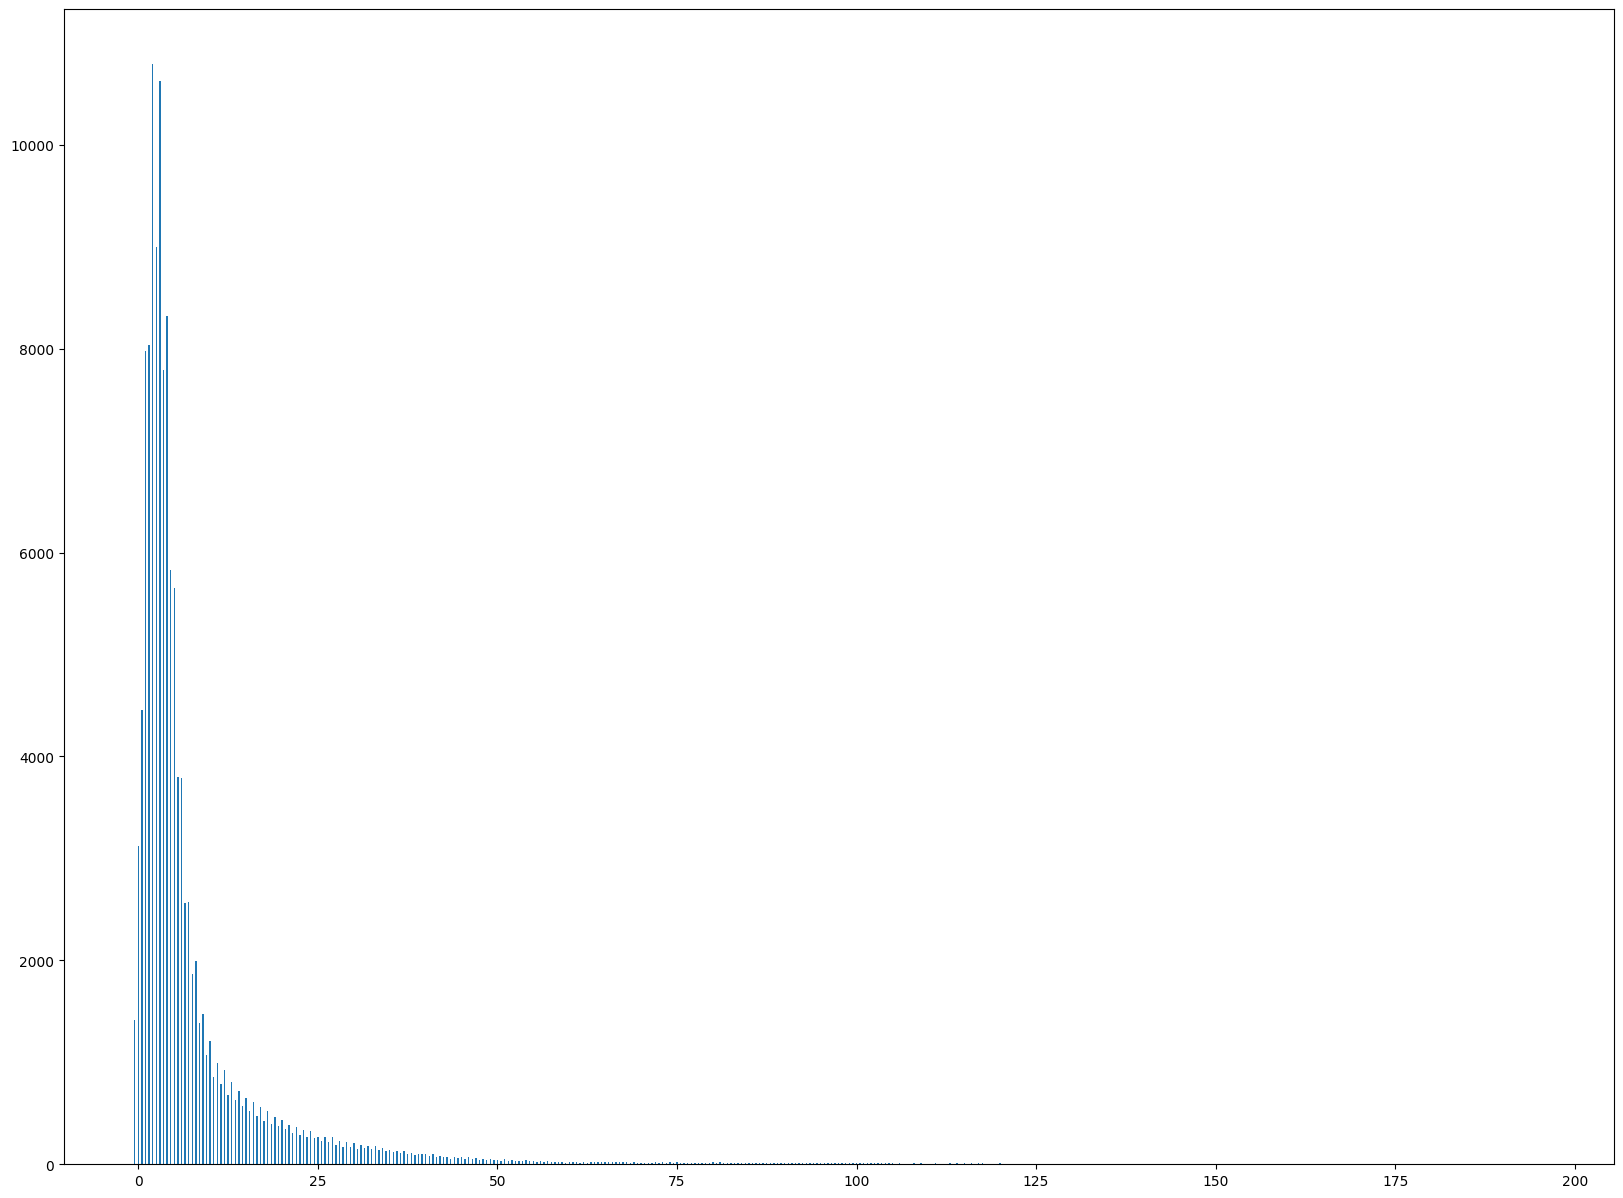

In [52]:
fig, axs = plt.subplots(figsize=(20, 15));
plt.bar(html_data["tfs_y"].value_counts().index, html_data["tfs_y"].value_counts(), width=0.2);

To have our data be more legible, what if we selected only `tfs_y`'s under 27? This means we're looking at companies that are founded at or after 1996.

In [53]:
html_data = html_data[html_data["founded_yr"] > 1996]

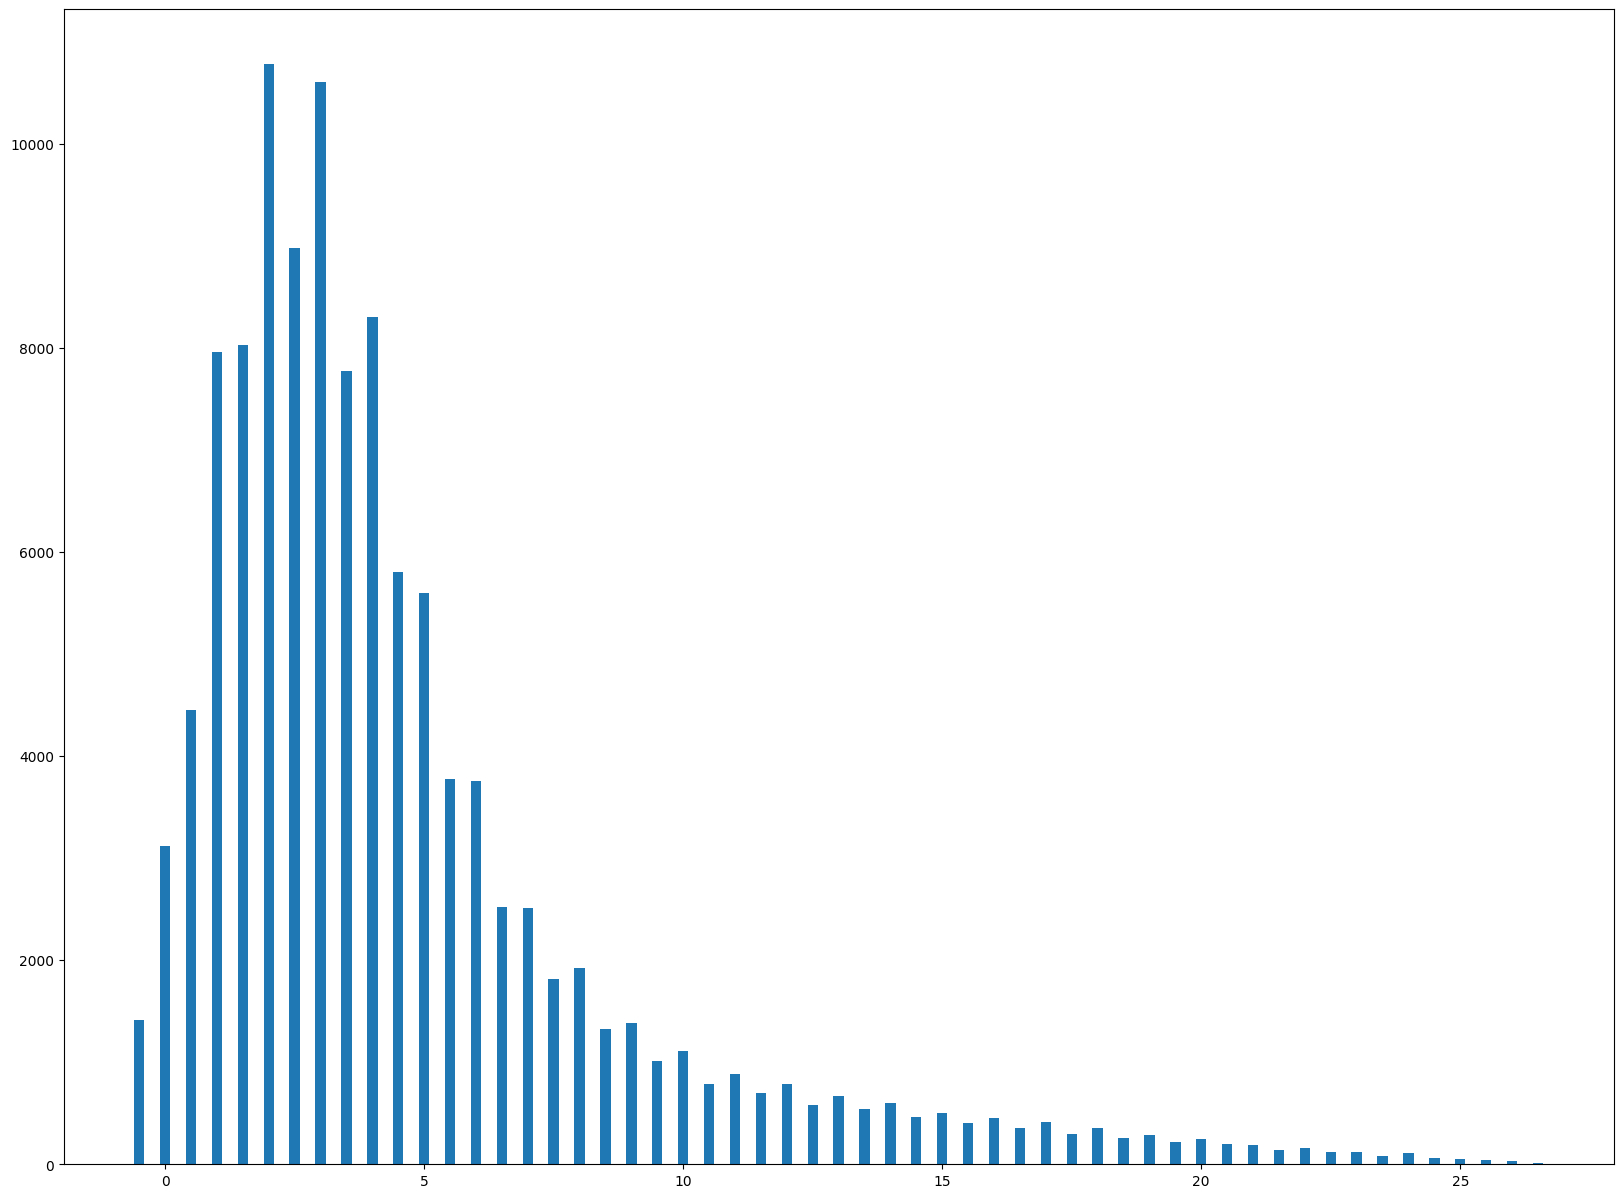

In [54]:
fig, axs = plt.subplots(figsize=(20, 15));
plt.bar(html_data["tfs_y"].value_counts().index, html_data["tfs_y"].value_counts(), width=0.2);

Data is still right-skewed, but significantly less so than before.

## 2. How old are companies when we first see their website?

_Goal is to be between 1 and 2_

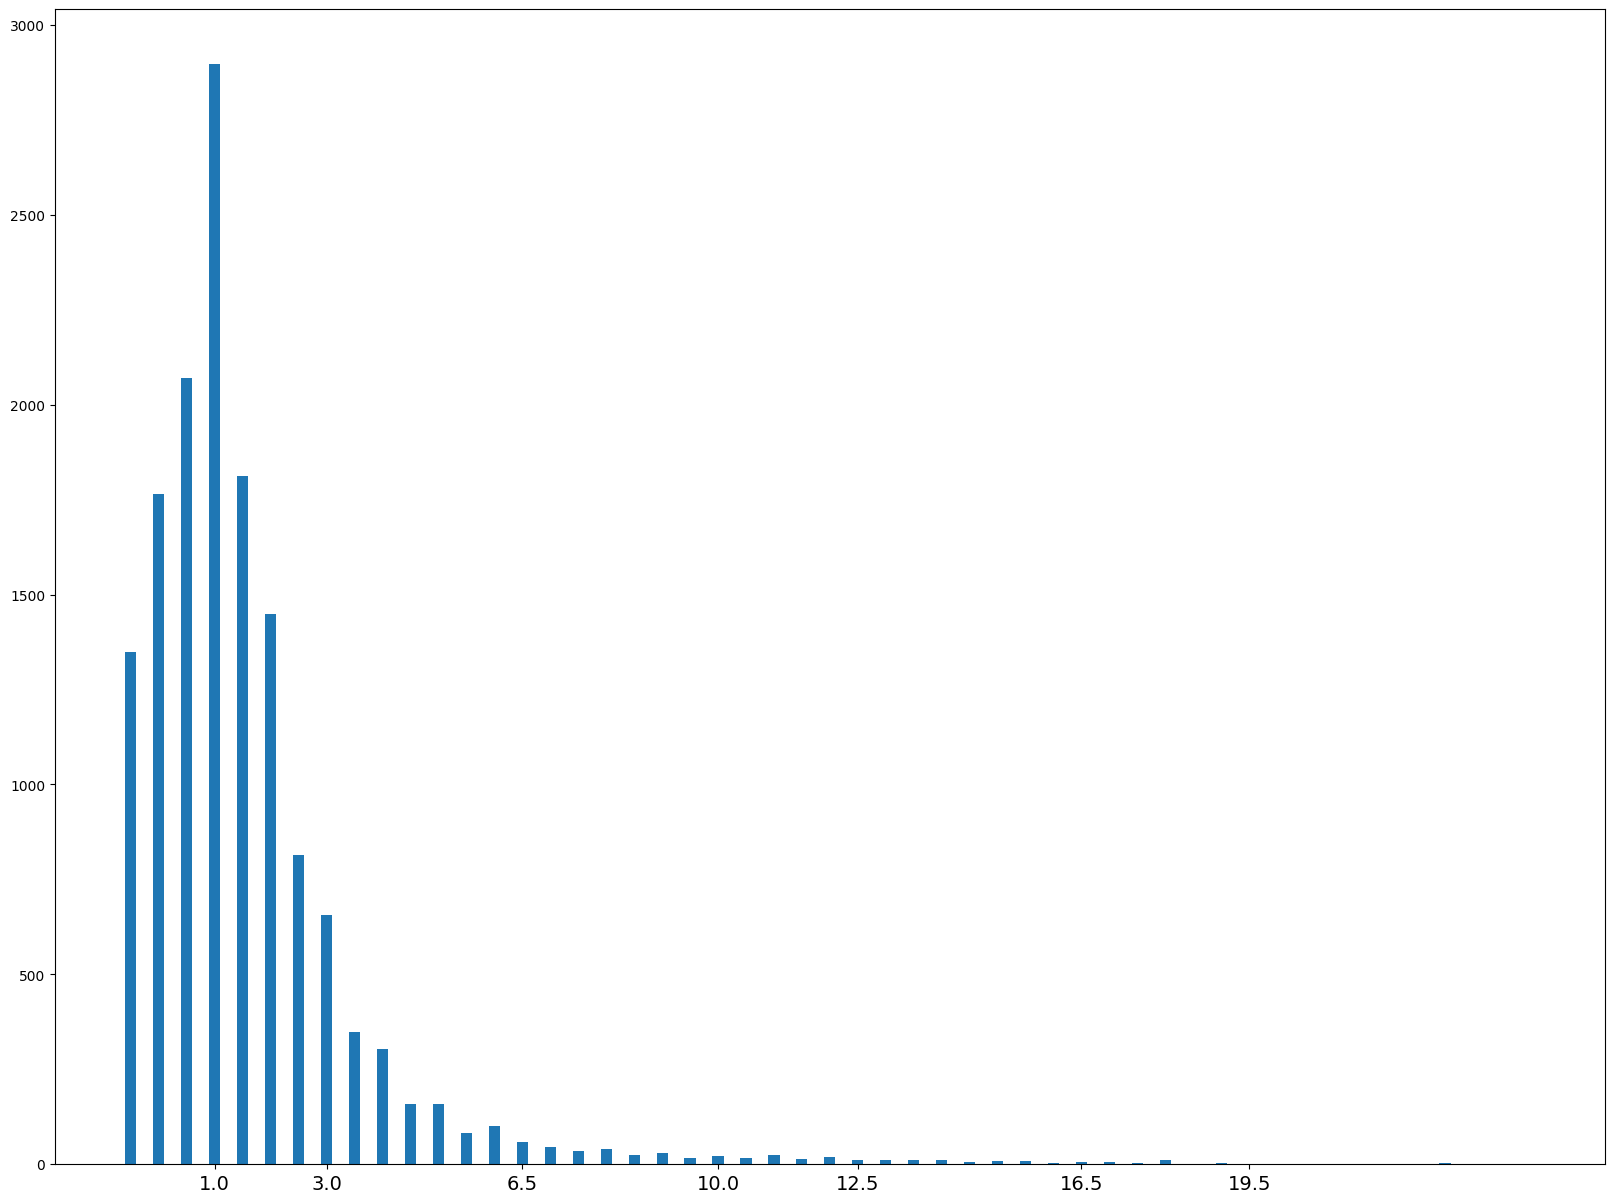

In [55]:
# Group by entityid, select min time_from_start_m
fig, axs = plt.subplots(figsize=(20, 15));
data = html_data.groupby('entityid')['tfs_y'].min().value_counts()
plt.bar(data.index, data, width=0.2);
plt.xticks(data.index[::7], fontsize=14);

In [56]:
data = html_data.groupby('entityid')['tfs_y'].min()
data = data[data <= 2]
html_data["ft_in_2"] = html_data['entityid'].isin(data.index)

## 3. Average number of links throughout company life-span

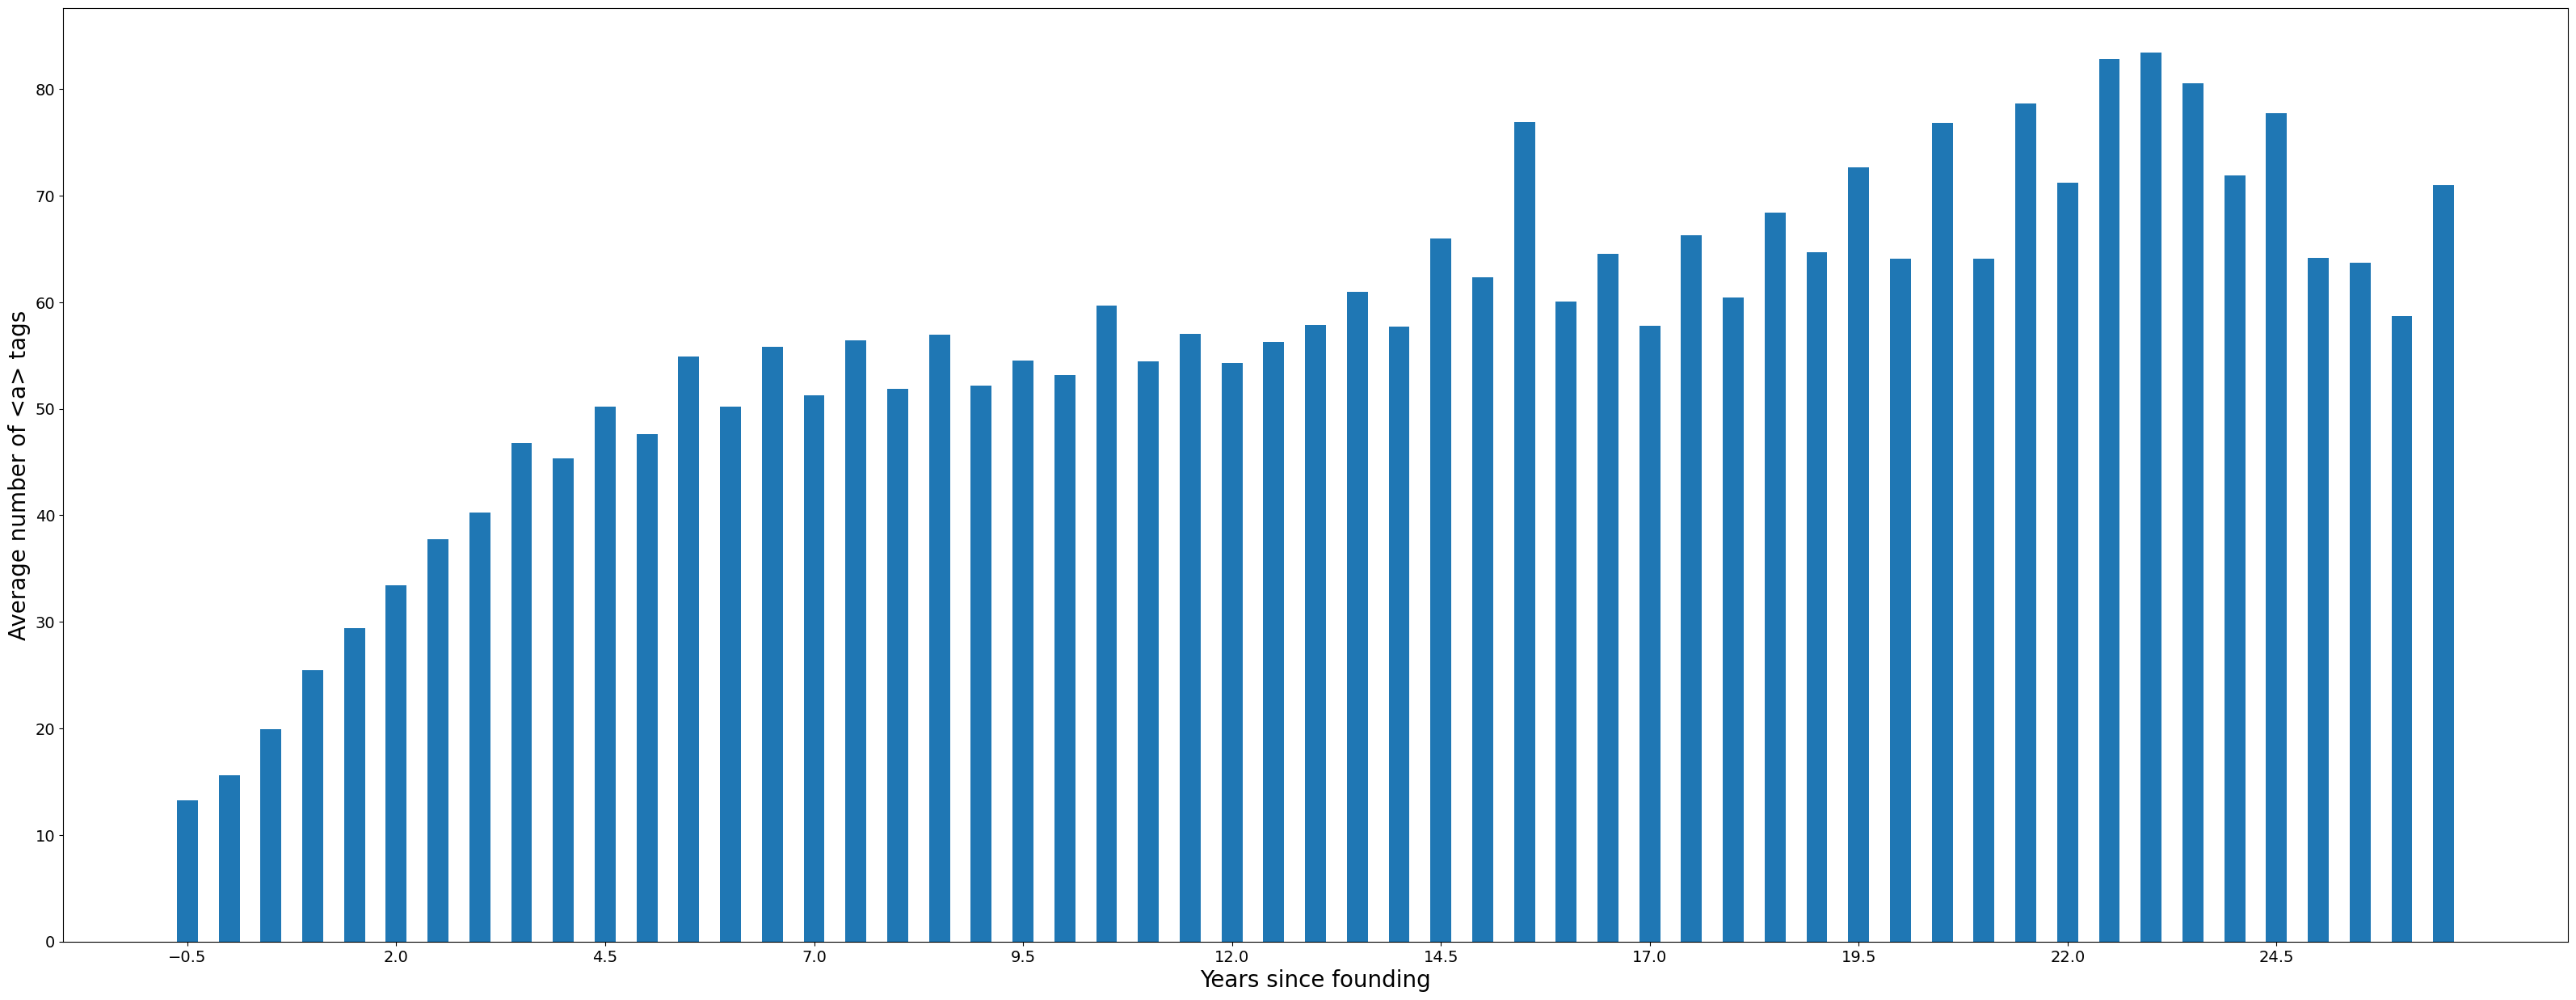

In [57]:
fig, axs = plt.subplots(figsize=(40, 15))

grouped_data = html_data.groupby(html_data["tfs_y"])["num_a_tags"].mean()
plt.bar(grouped_data.index, grouped_data, width=0.25)
plt.xticks(grouped_data.index[::5], fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Years since founding", fontsize=20);
plt.ylabel("Average number of <a> tags", fontsize=20);

Speed at which it adds links?

Is link growth of 10% a year significant?

### 3.1 2019 Example

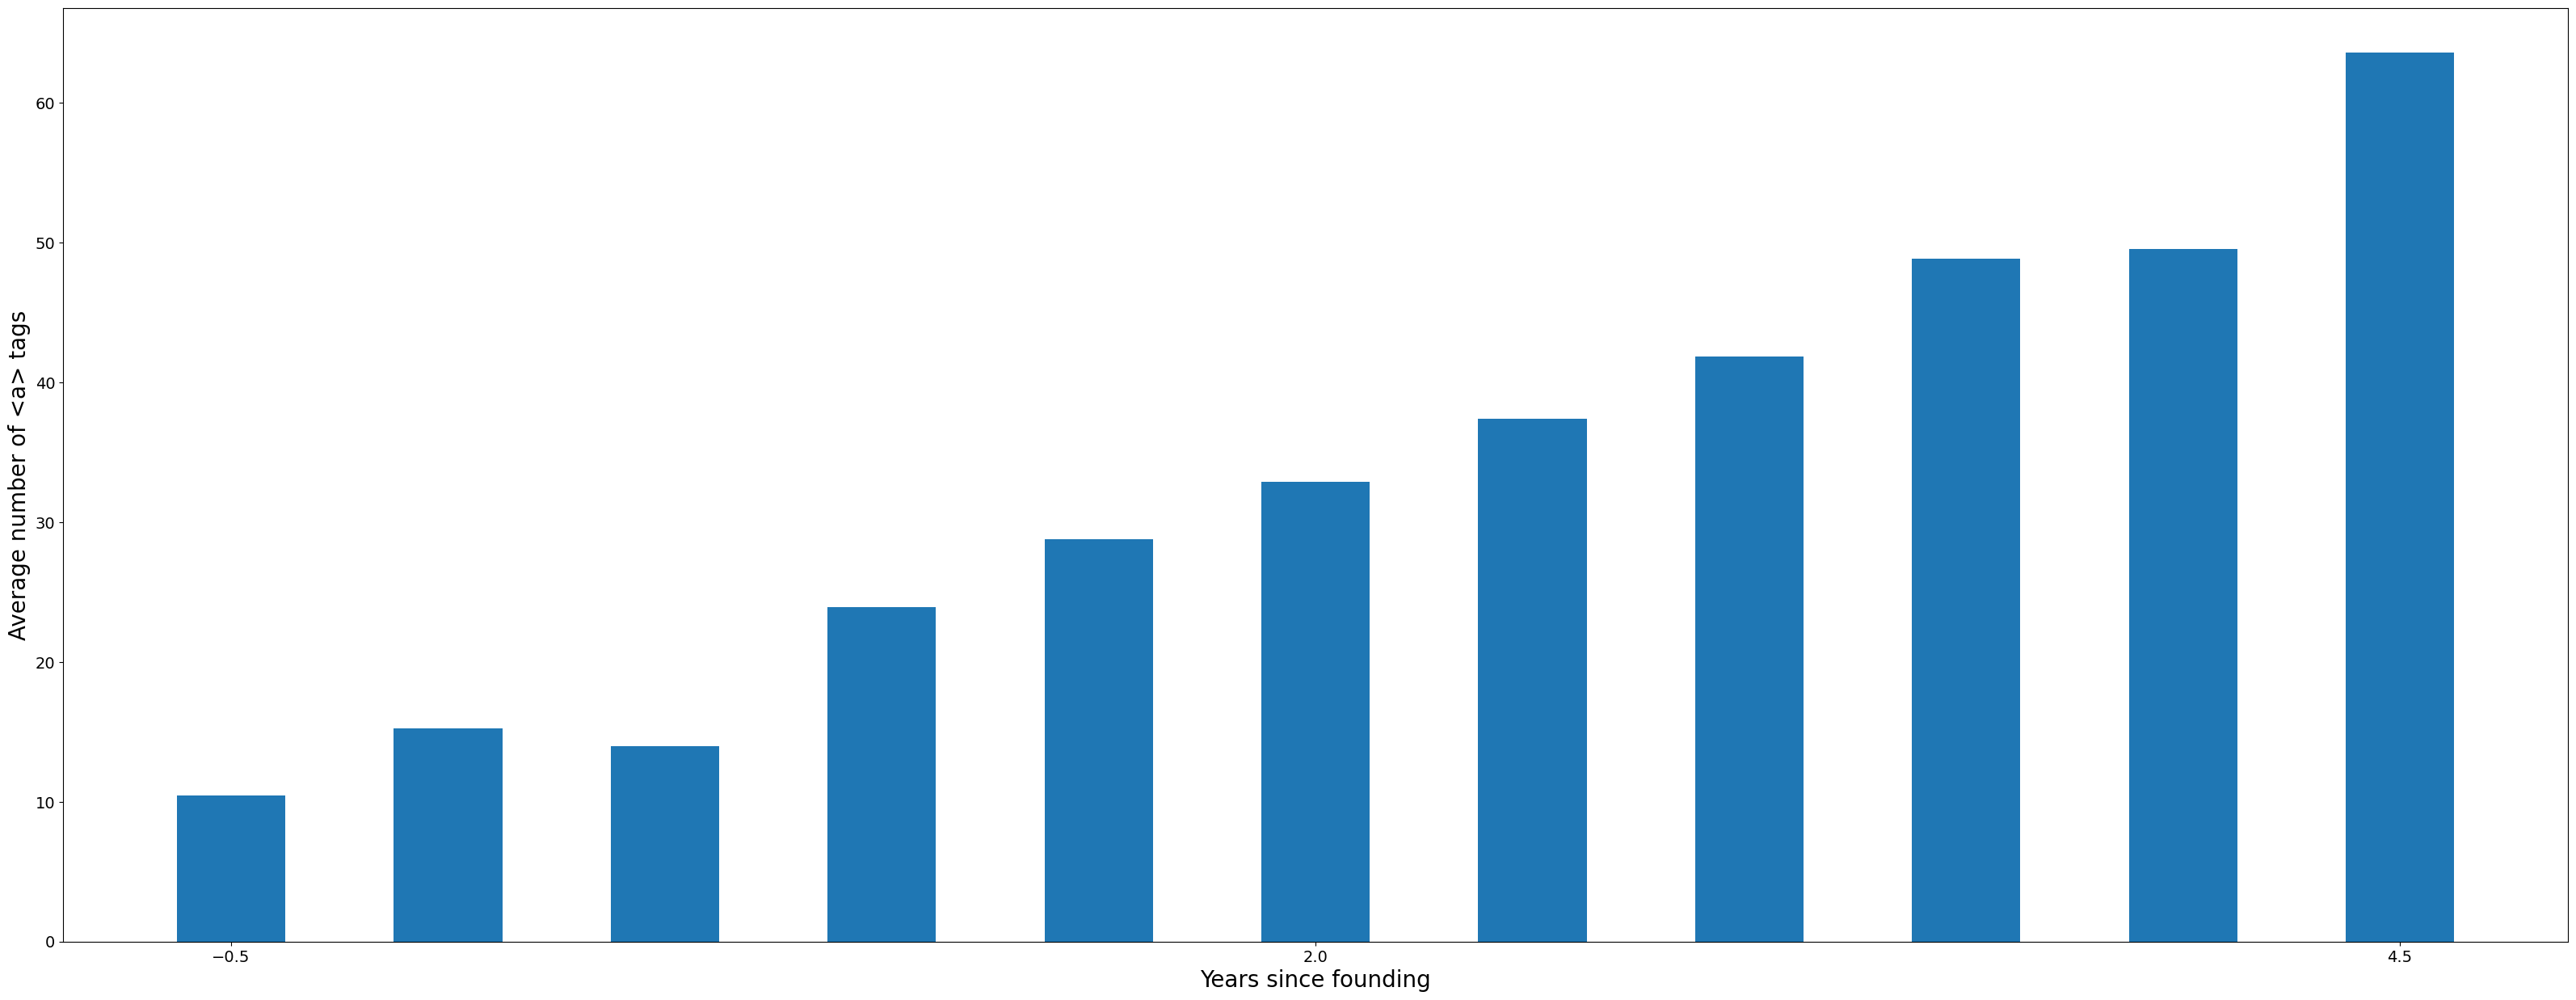

In [58]:
fig, axs = plt.subplots(figsize=(40, 15))

grouped_data = html_data[html_data["founded_yr"] == 2019].groupby(html_data["tfs_y"])["num_a_tags"].mean()
plt.bar(grouped_data.index, grouped_data, width=0.25)
plt.xticks(grouped_data.index[::5], fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Years since founding", fontsize=20);
plt.ylabel("Average number of <a> tags", fontsize=20);

### 3.2 1999 Example

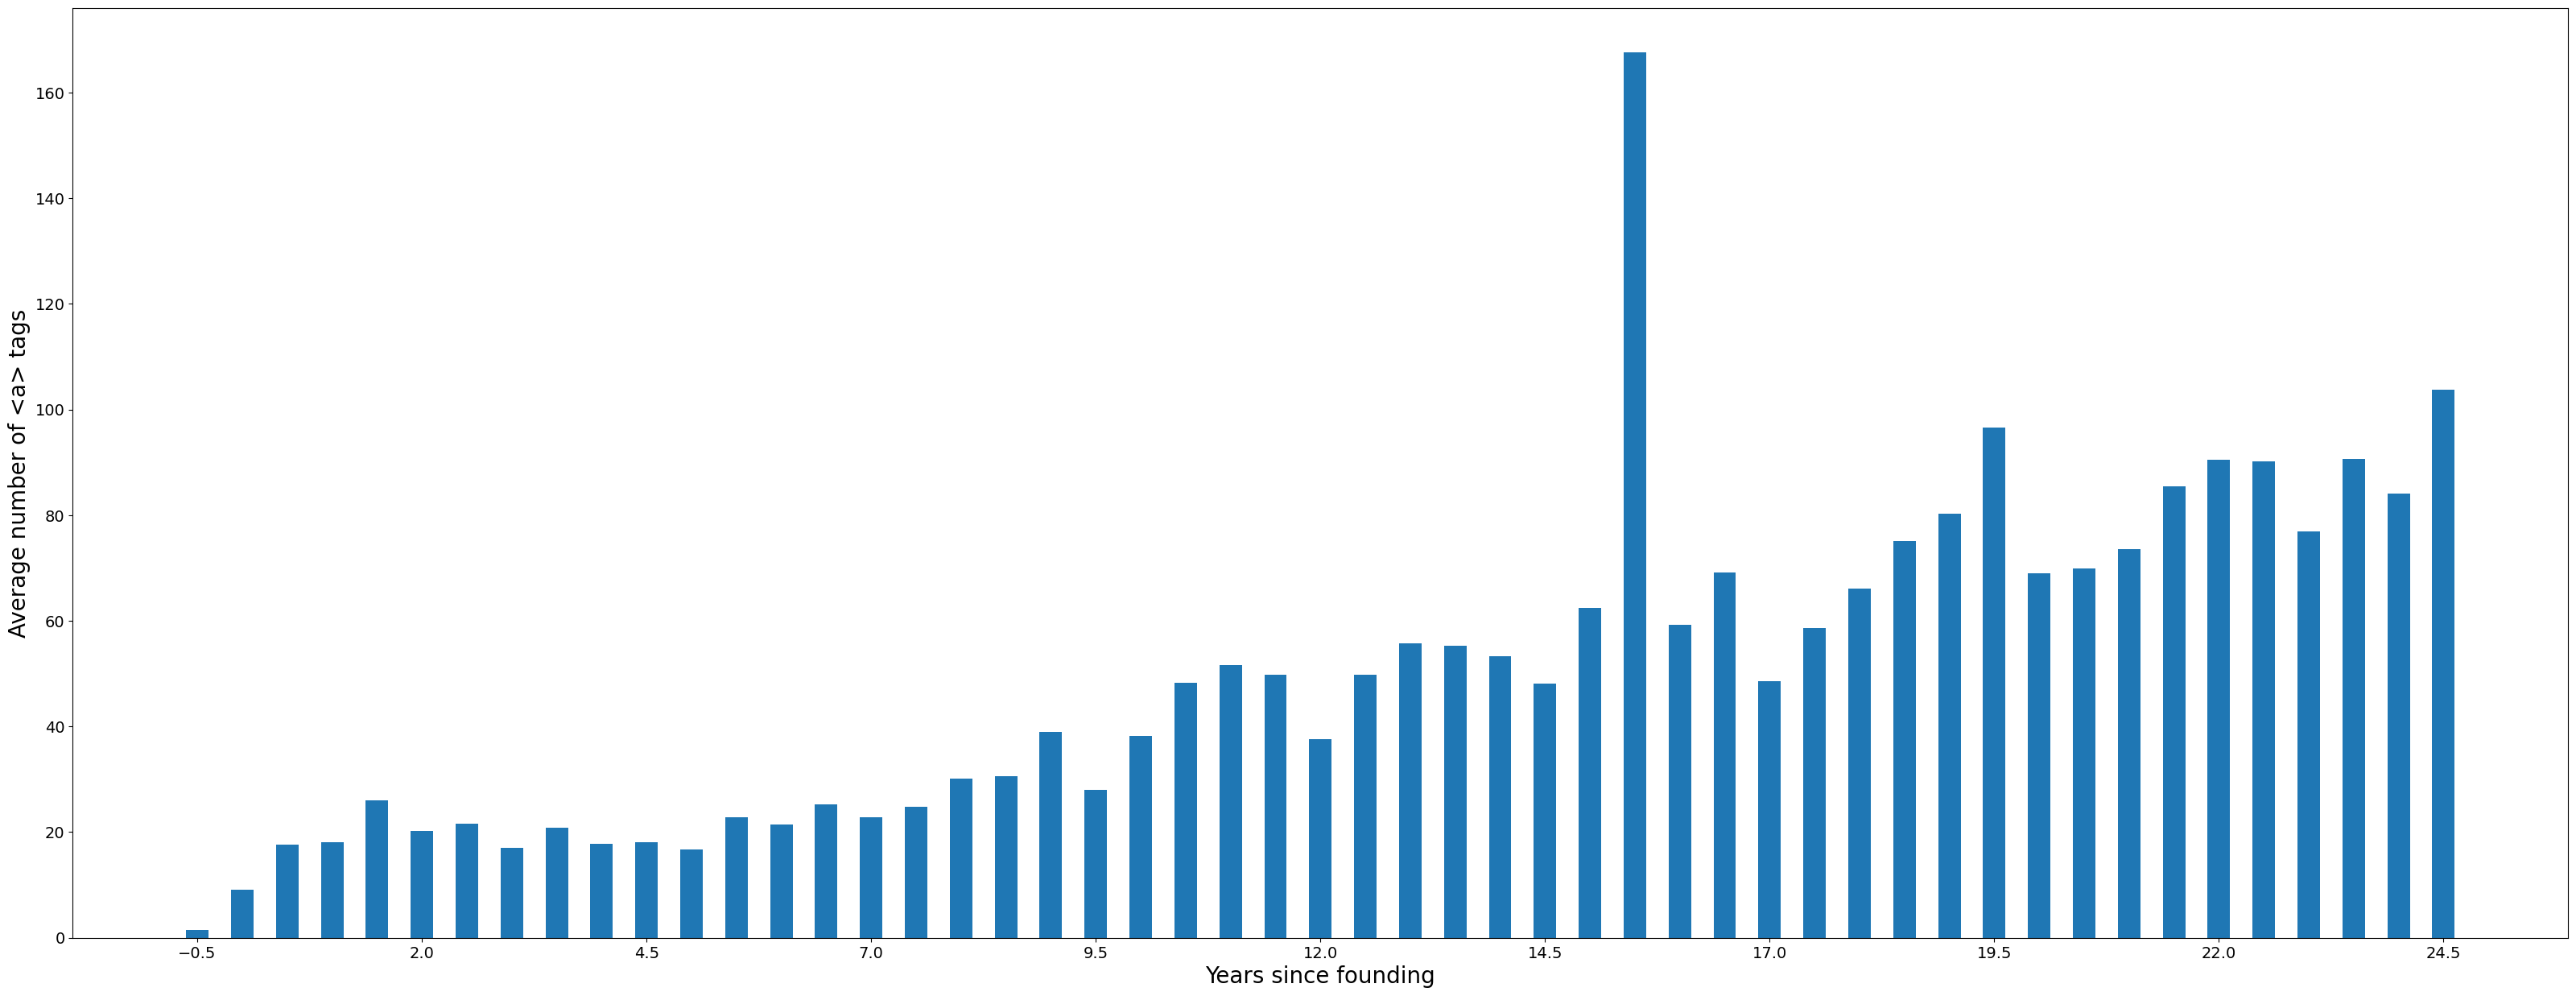

In [59]:
fig, axs = plt.subplots(figsize=(40, 15))

grouped_data = html_data[html_data["founded_yr"] == 1999].groupby(html_data["tfs_y"])["num_a_tags"].mean()
plt.bar(grouped_data.index, grouped_data, width=0.25)
plt.xticks(grouped_data.index[::5], fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Years since founding", fontsize=20);
plt.ylabel("Average number of <a> tags", fontsize=20);

That one spike at 15.5 years is odd...how many companies are we looking at anyway?

In [60]:
pd.unique(html_data[html_data["founded_yr"] == 1999]["entityid"]).size

74

## 4. Webpage size time series

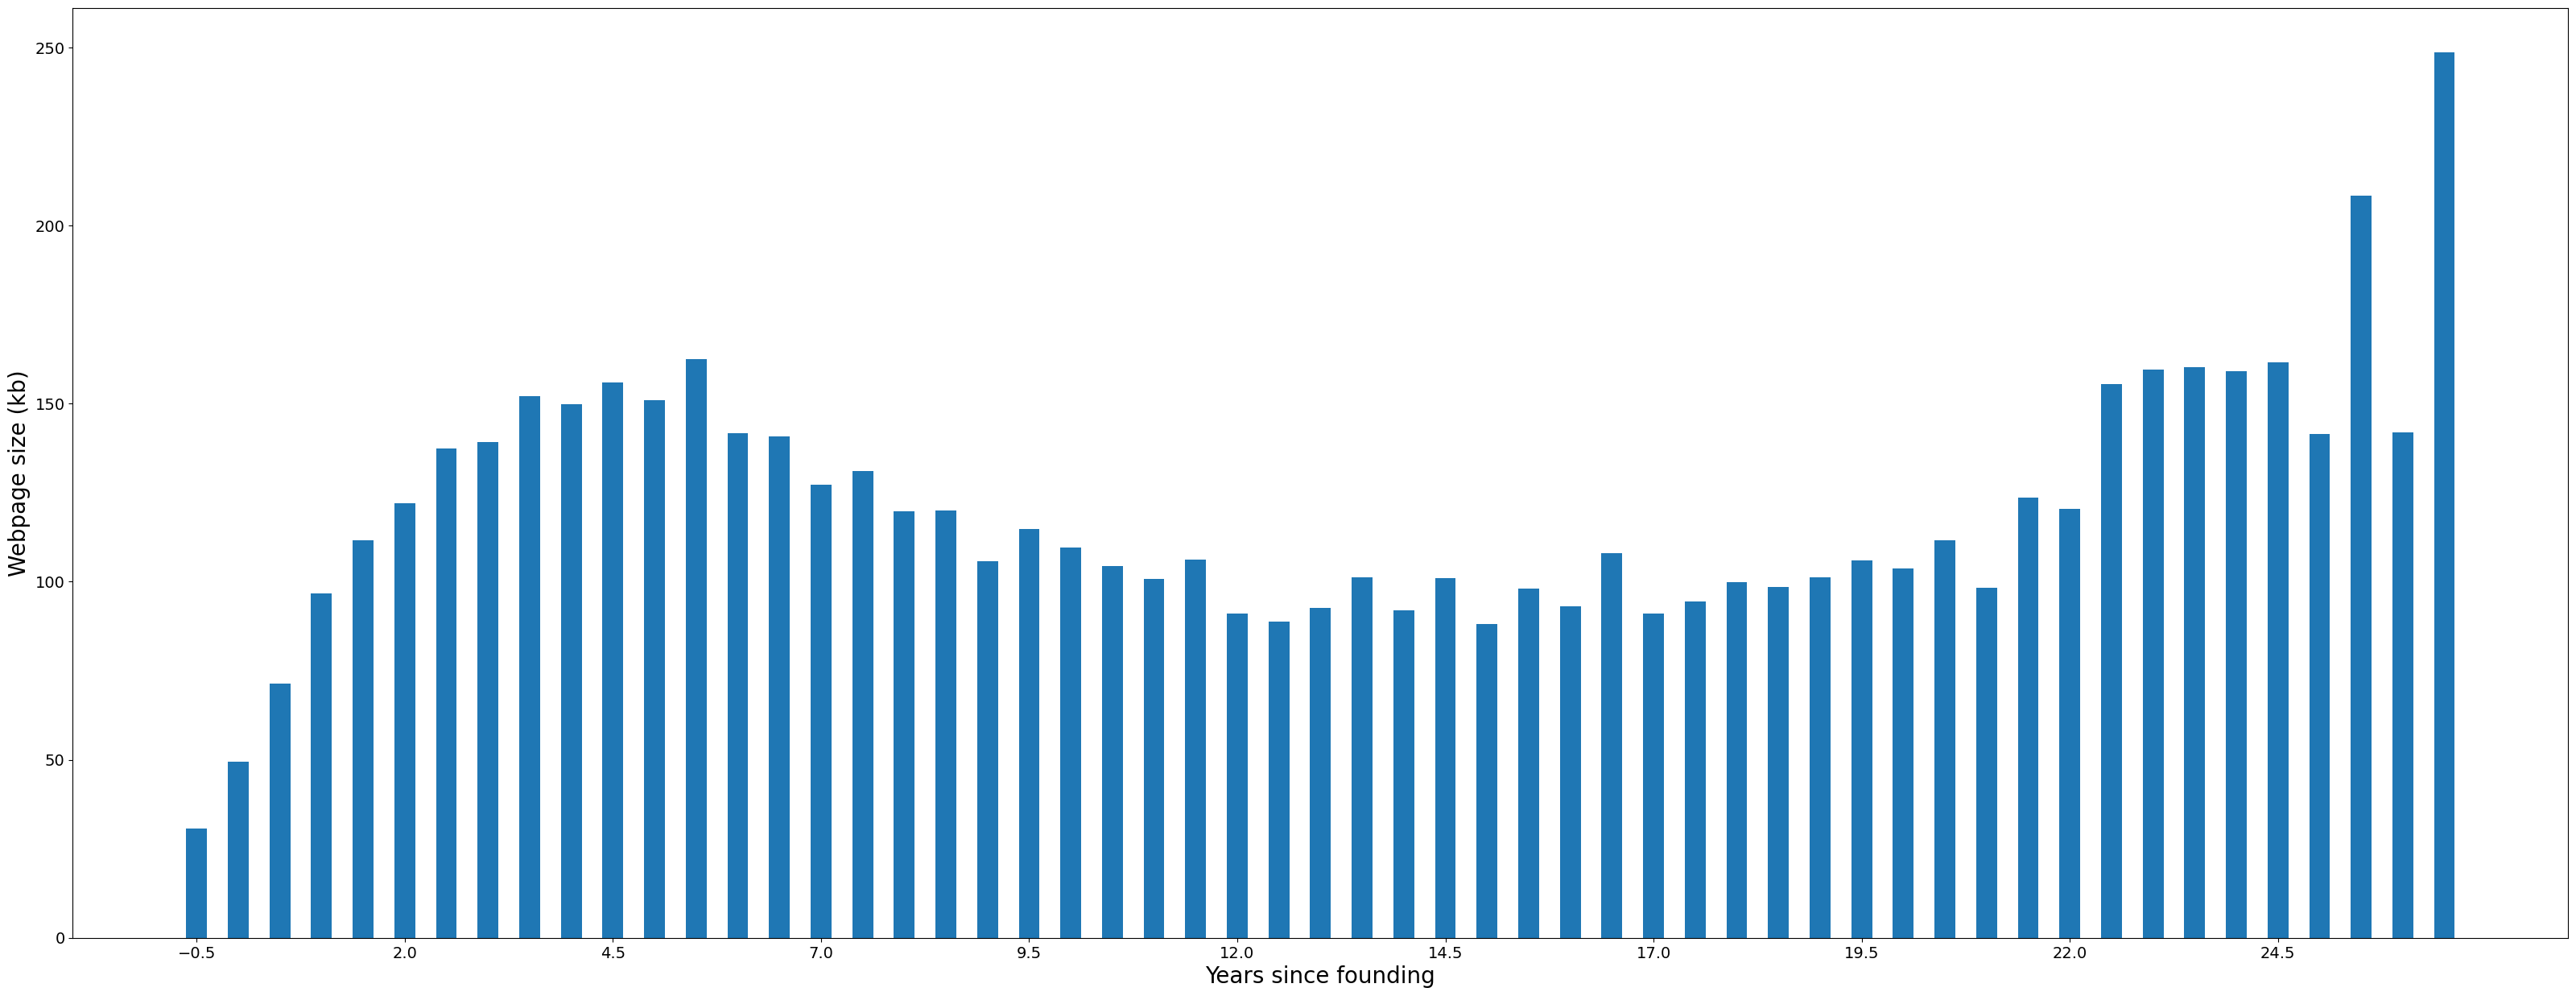

In [61]:
fig, axs = plt.subplots(figsize=(40, 15))
grouped_data = html_data.groupby(html_data["tfs_y"])["website_size_kb"].mean()
plt.bar(grouped_data.index, grouped_data, width=0.25)
plt.xticks(grouped_data.index[::5], fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Years since founding", fontsize=20);
plt.ylabel("Webpage size (kb)", fontsize=20);

### 4.1 Website size over year captured (`capture_yr`)

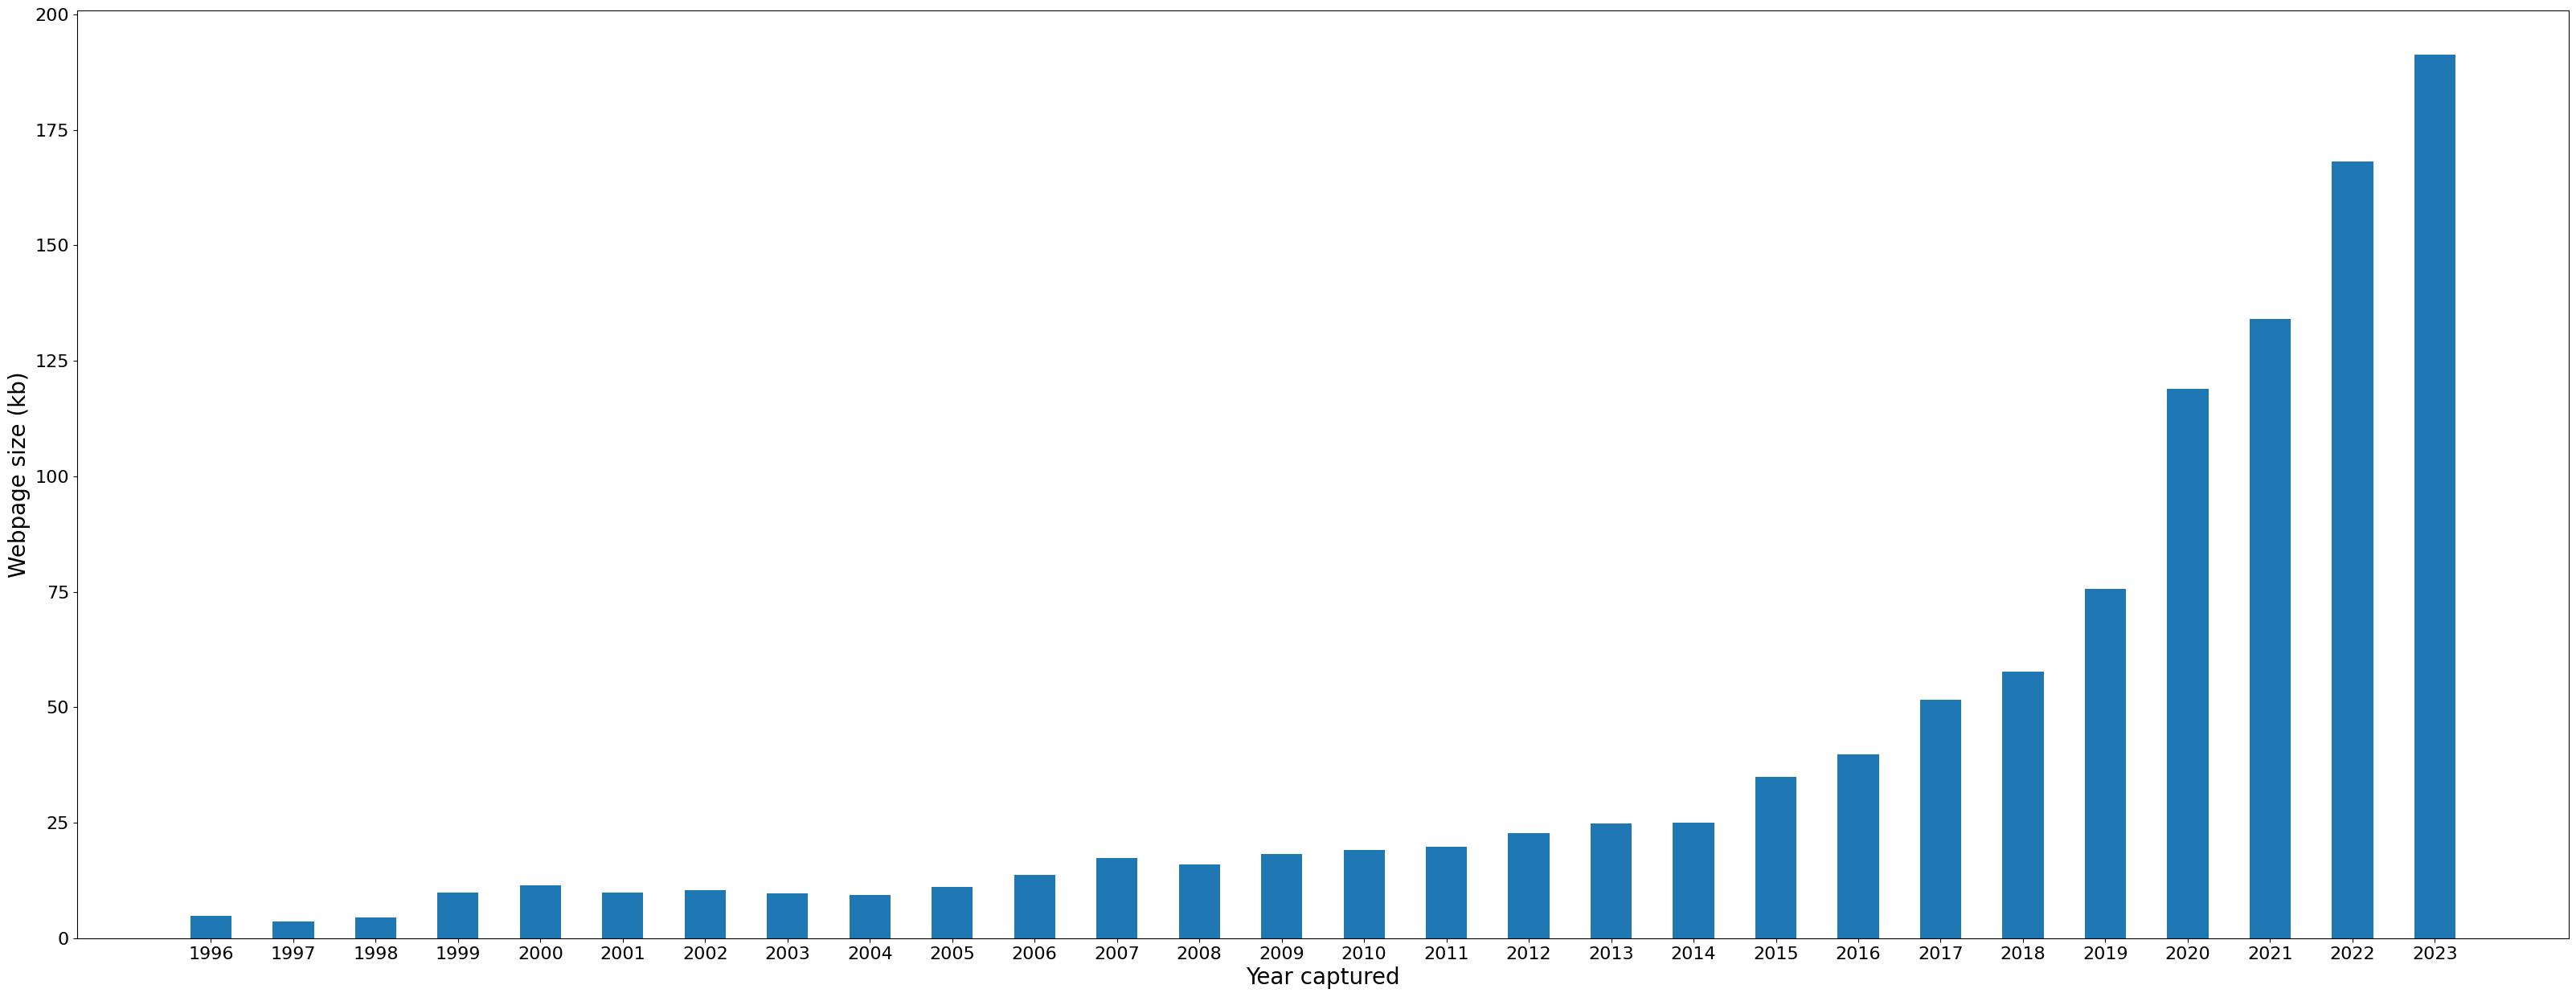

In [62]:
fig, axs = plt.subplots(figsize=(40, 15))
grouped_data = html_data.groupby(html_data["capture_yr"])["website_size_kb"].mean()
plt.bar(grouped_data.index, grouped_data, width=0.5)
plt.xticks(grouped_data.index, fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Year captured", fontsize=20);
plt.ylabel("Webpage size (kb)", fontsize=20);

**Survivorship problem:**

The companies defining the mean are the ones that are alive.

*New approach:*
For all companies that survived at least five years, what does the size path look like from 0-5

Ditto survived 10 years, 0-10.

For firms that go public vs acquired, does their website grow in different ways?

Look out for cohort effect - all companies that exit in the same years...

### 4.2 For companies that have been around for at least 5 years?

In [63]:
# Select companies that have survived at least five years...
html_data["real_exit"] = html_data["exit_date"].isna() == False
html_data["end_yr"] = html_data["exit_date"].str.slice(start=0, stop=4)
html_data["end_yr"] = html_data["end_yr"].fillna(2023)
html_data["end_yr"] = html_data["end_yr"].astype(int)

That seems like a lot of companies with missing exit dates. How many companies?

In [64]:
pd.unique(html_data[html_data["end_yr"] == 2023]["entityid"]).size

14357

...out of 

In [65]:
pd.unique(html_data["entityid"]).size

14782

...moving on...

In [66]:
html_data["life_span_yrs"] = html_data["end_yr"] - html_data["founded_yr"]

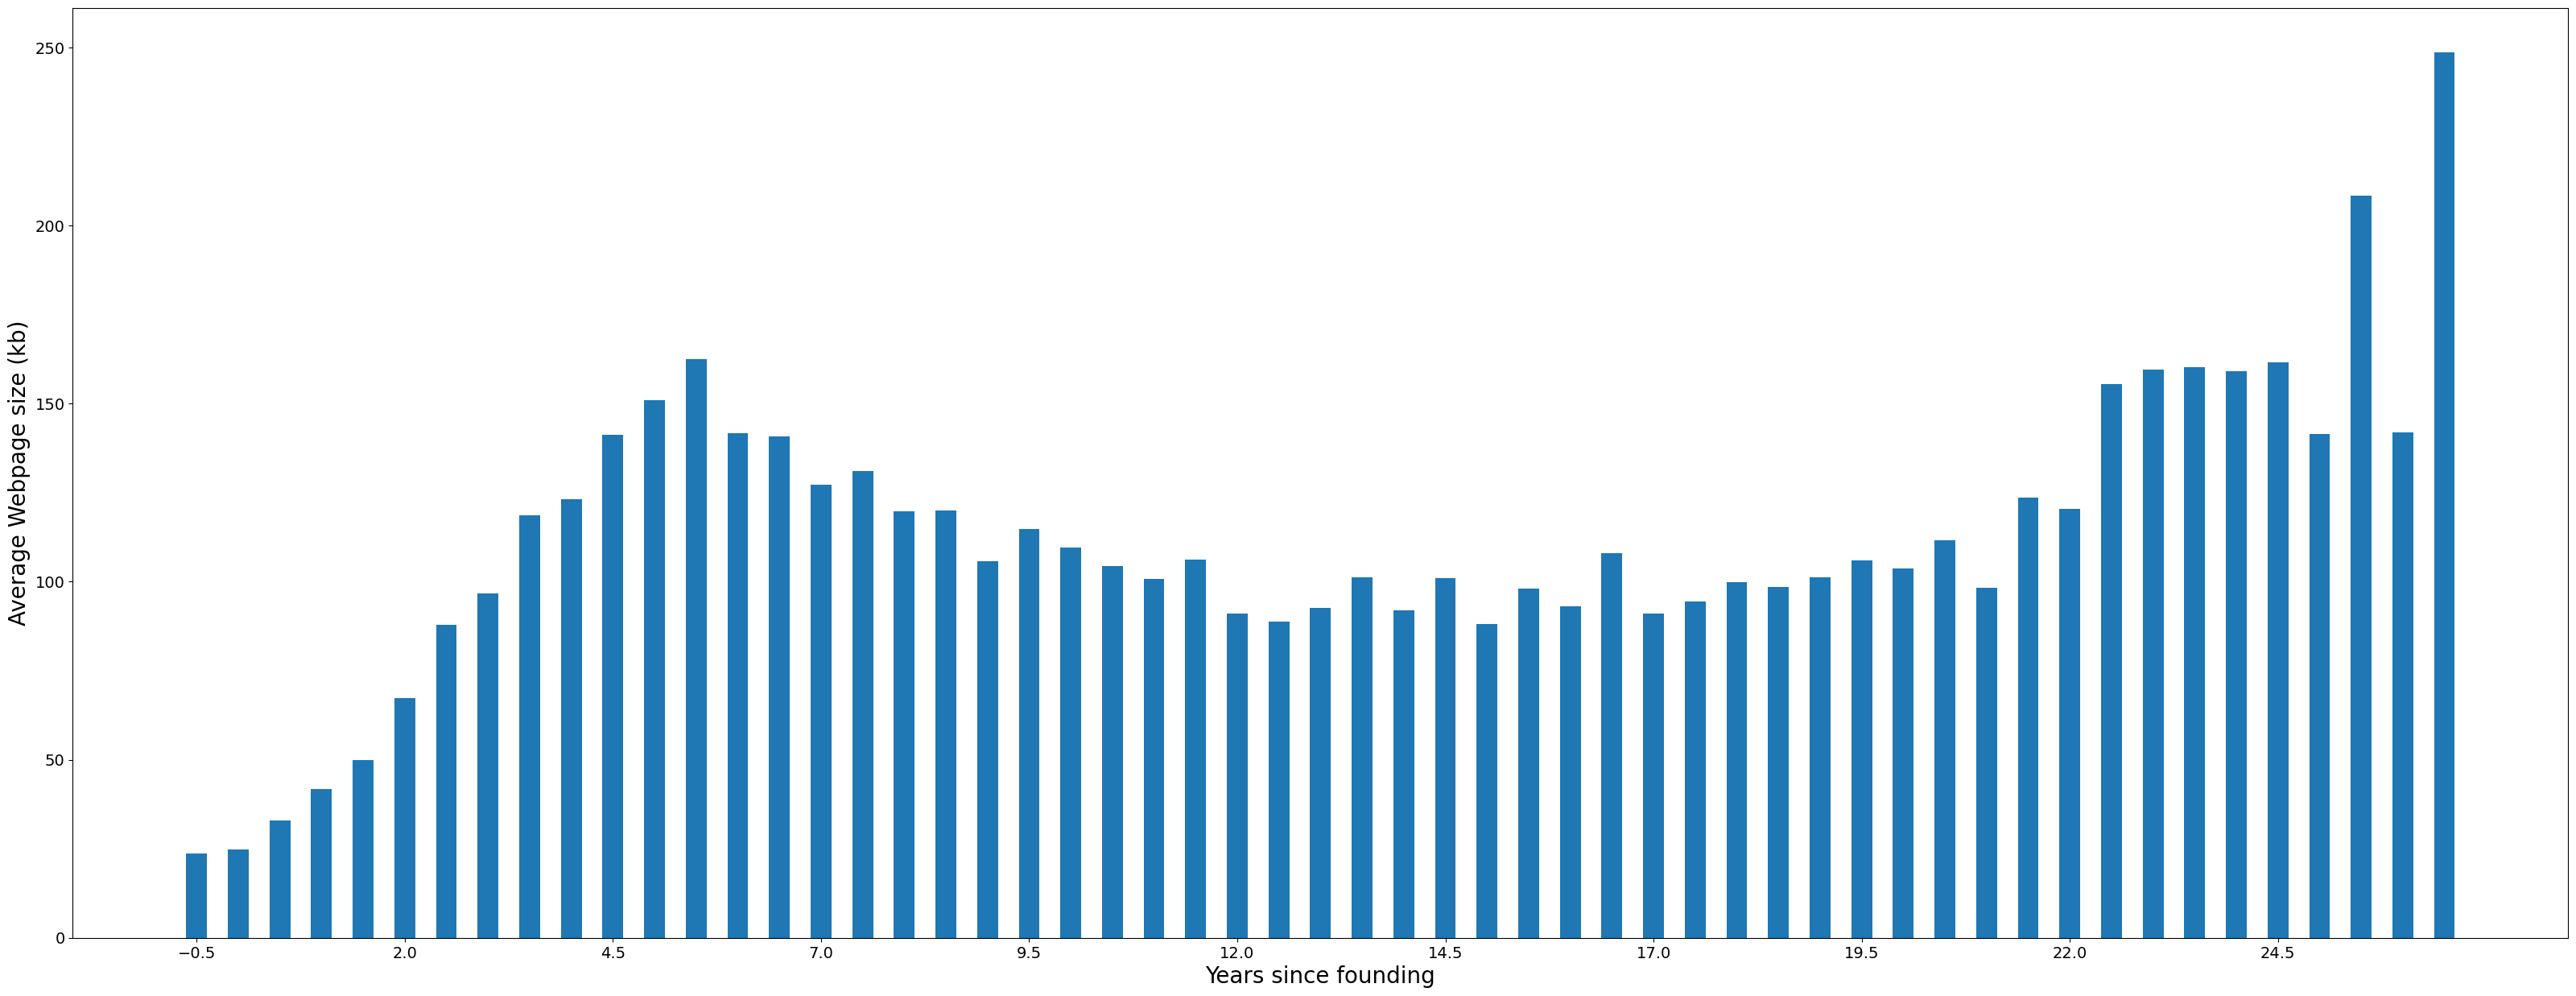

In [67]:
fig, axs = plt.subplots(figsize=(40, 15))
html_d_subset = html_data[html_data["life_span_yrs"] >= 5]
grouped_data = html_d_subset.groupby(html_d_subset["tfs_y"])["website_size_kb"].mean()
plt.bar(grouped_data.index, grouped_data, width=0.25)
plt.xticks(grouped_data.index[::5], fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Years since founding", fontsize=20);
plt.ylabel("Average Webpage size (kb)", fontsize=20);

### 4.3 10+ years?

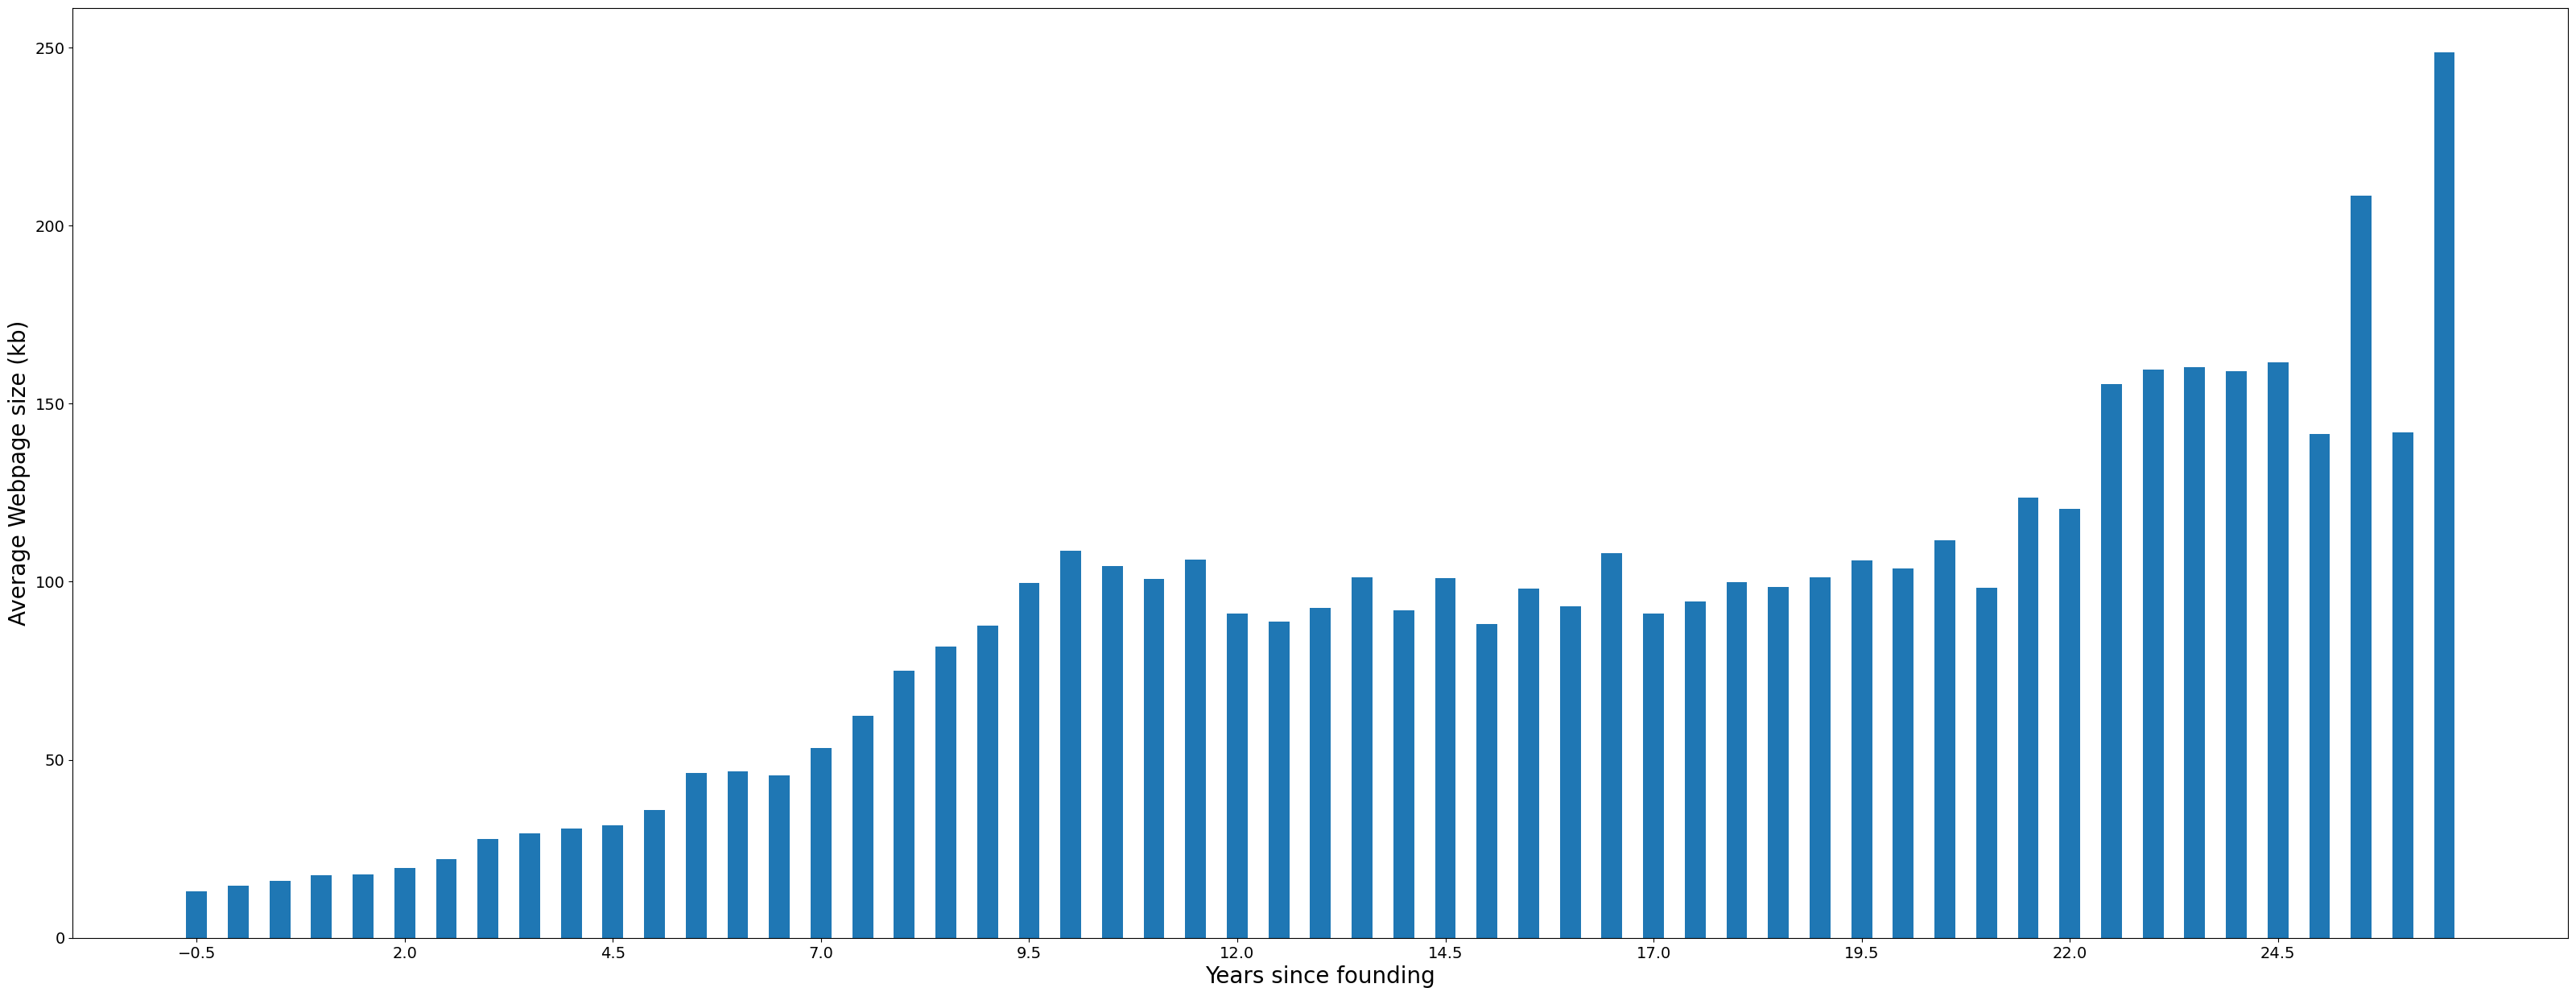

In [68]:
fig, axs = plt.subplots(figsize=(40, 15))
html_d_subset = html_data[html_data["life_span_yrs"] >= 10]
grouped_data = html_d_subset.groupby(html_d_subset["tfs_y"])["website_size_kb"].mean()
plt.bar(grouped_data.index, grouped_data, width=0.25)
plt.xticks(grouped_data.index[::5], fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Years since founding", fontsize=20);
plt.ylabel("Average Webpage size (kb)", fontsize=20);

### 4.4 For companies that got their first their first timestamp within 0-2 years of the founding date?

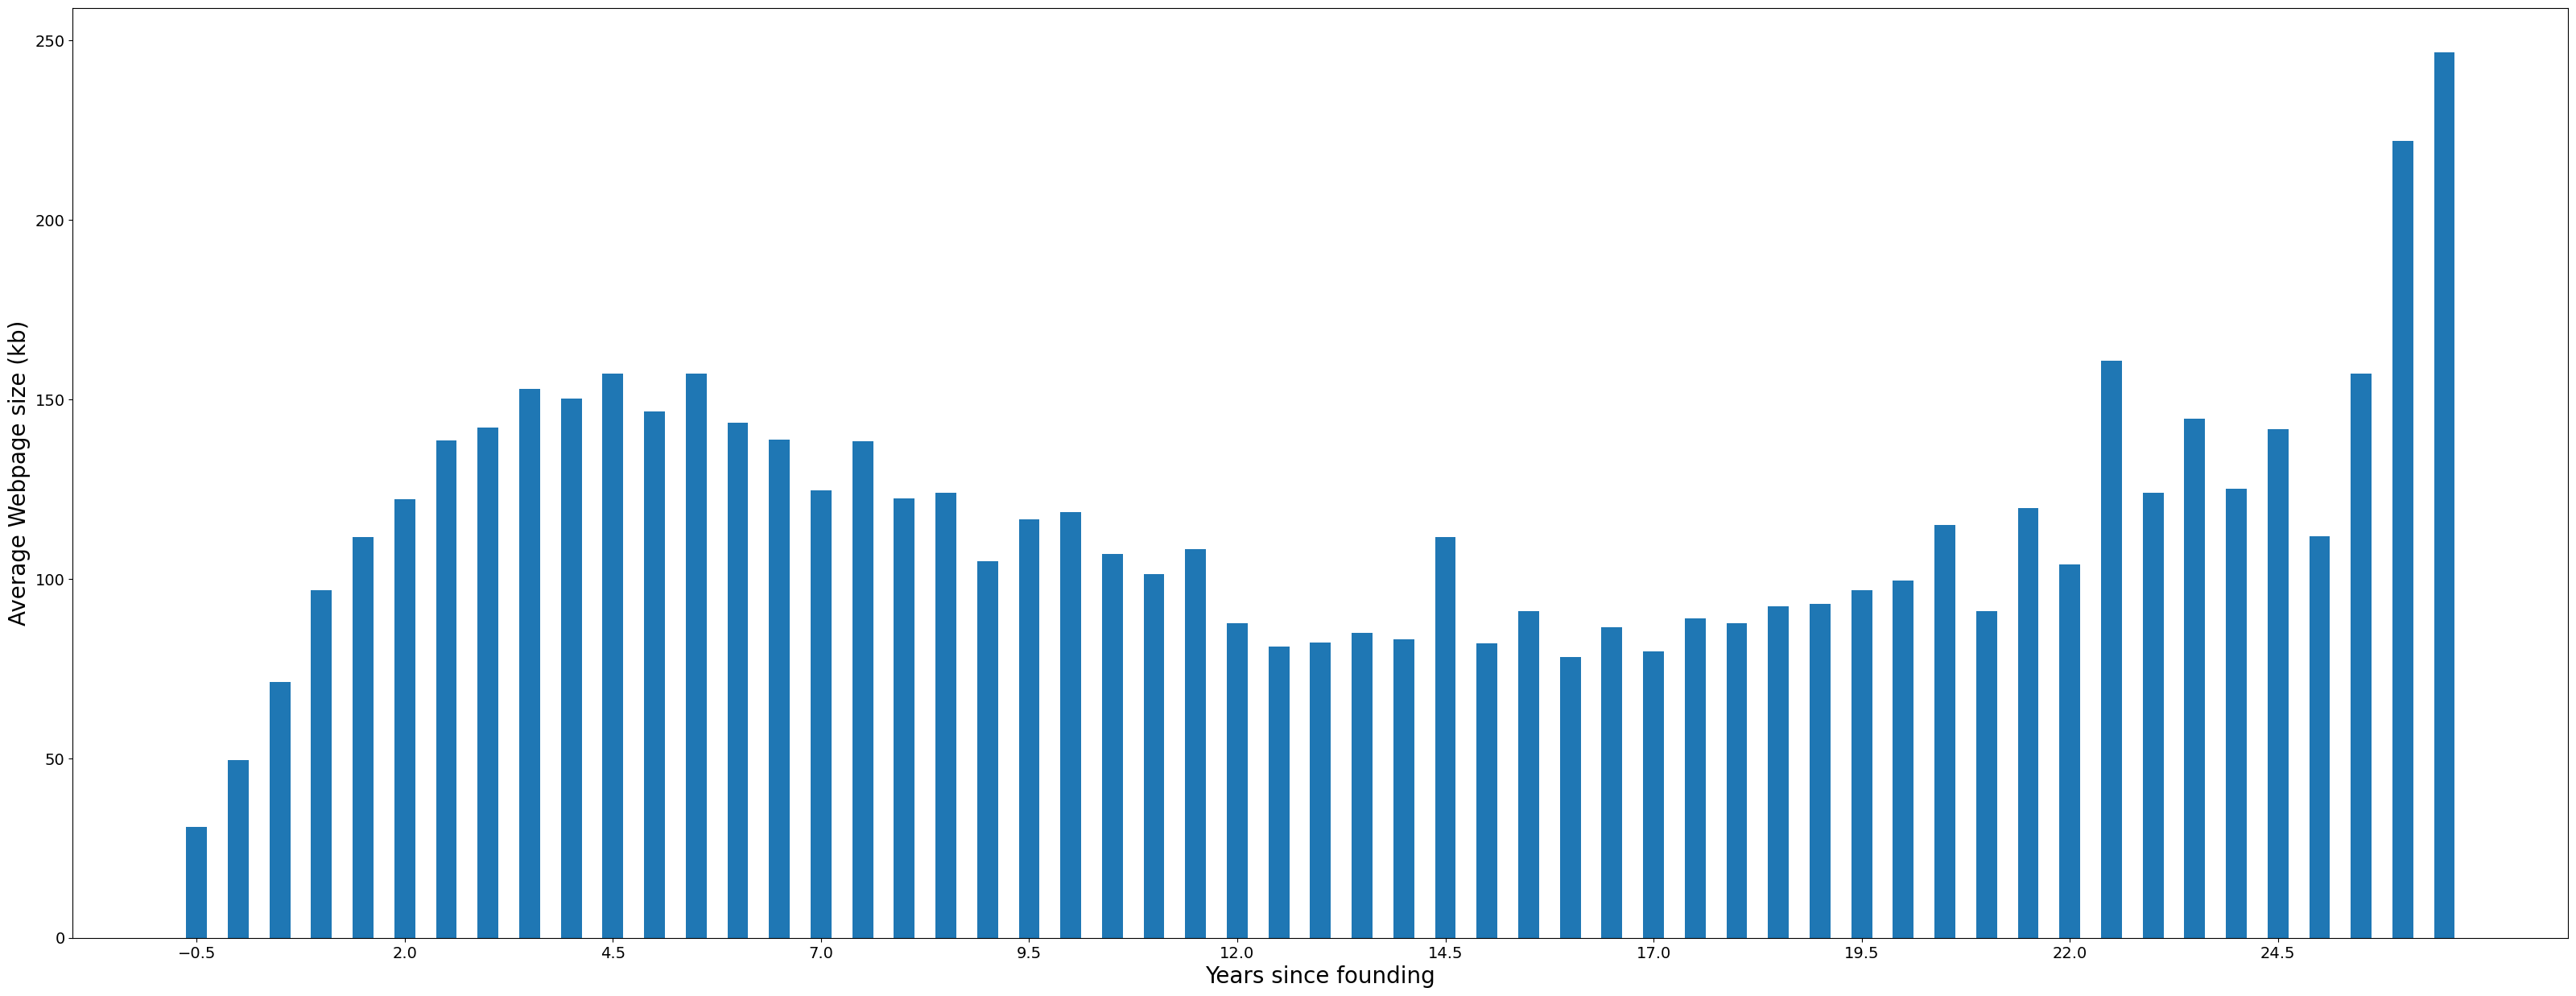

In [69]:
fig, axs = plt.subplots(figsize=(40, 15))
html_d_subset = html_data[html_data['ft_in_2']]
grouped_data = html_d_subset.groupby(html_d_subset["tfs_y"])["website_size_kb"].mean()
plt.bar(grouped_data.index, grouped_data, width=0.25)
plt.xticks(grouped_data.index[::5], fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Years since founding", fontsize=20);
plt.ylabel("Average Webpage size (kb)", fontsize=20);

## 5. Meta tag time series

### 5.1 Description

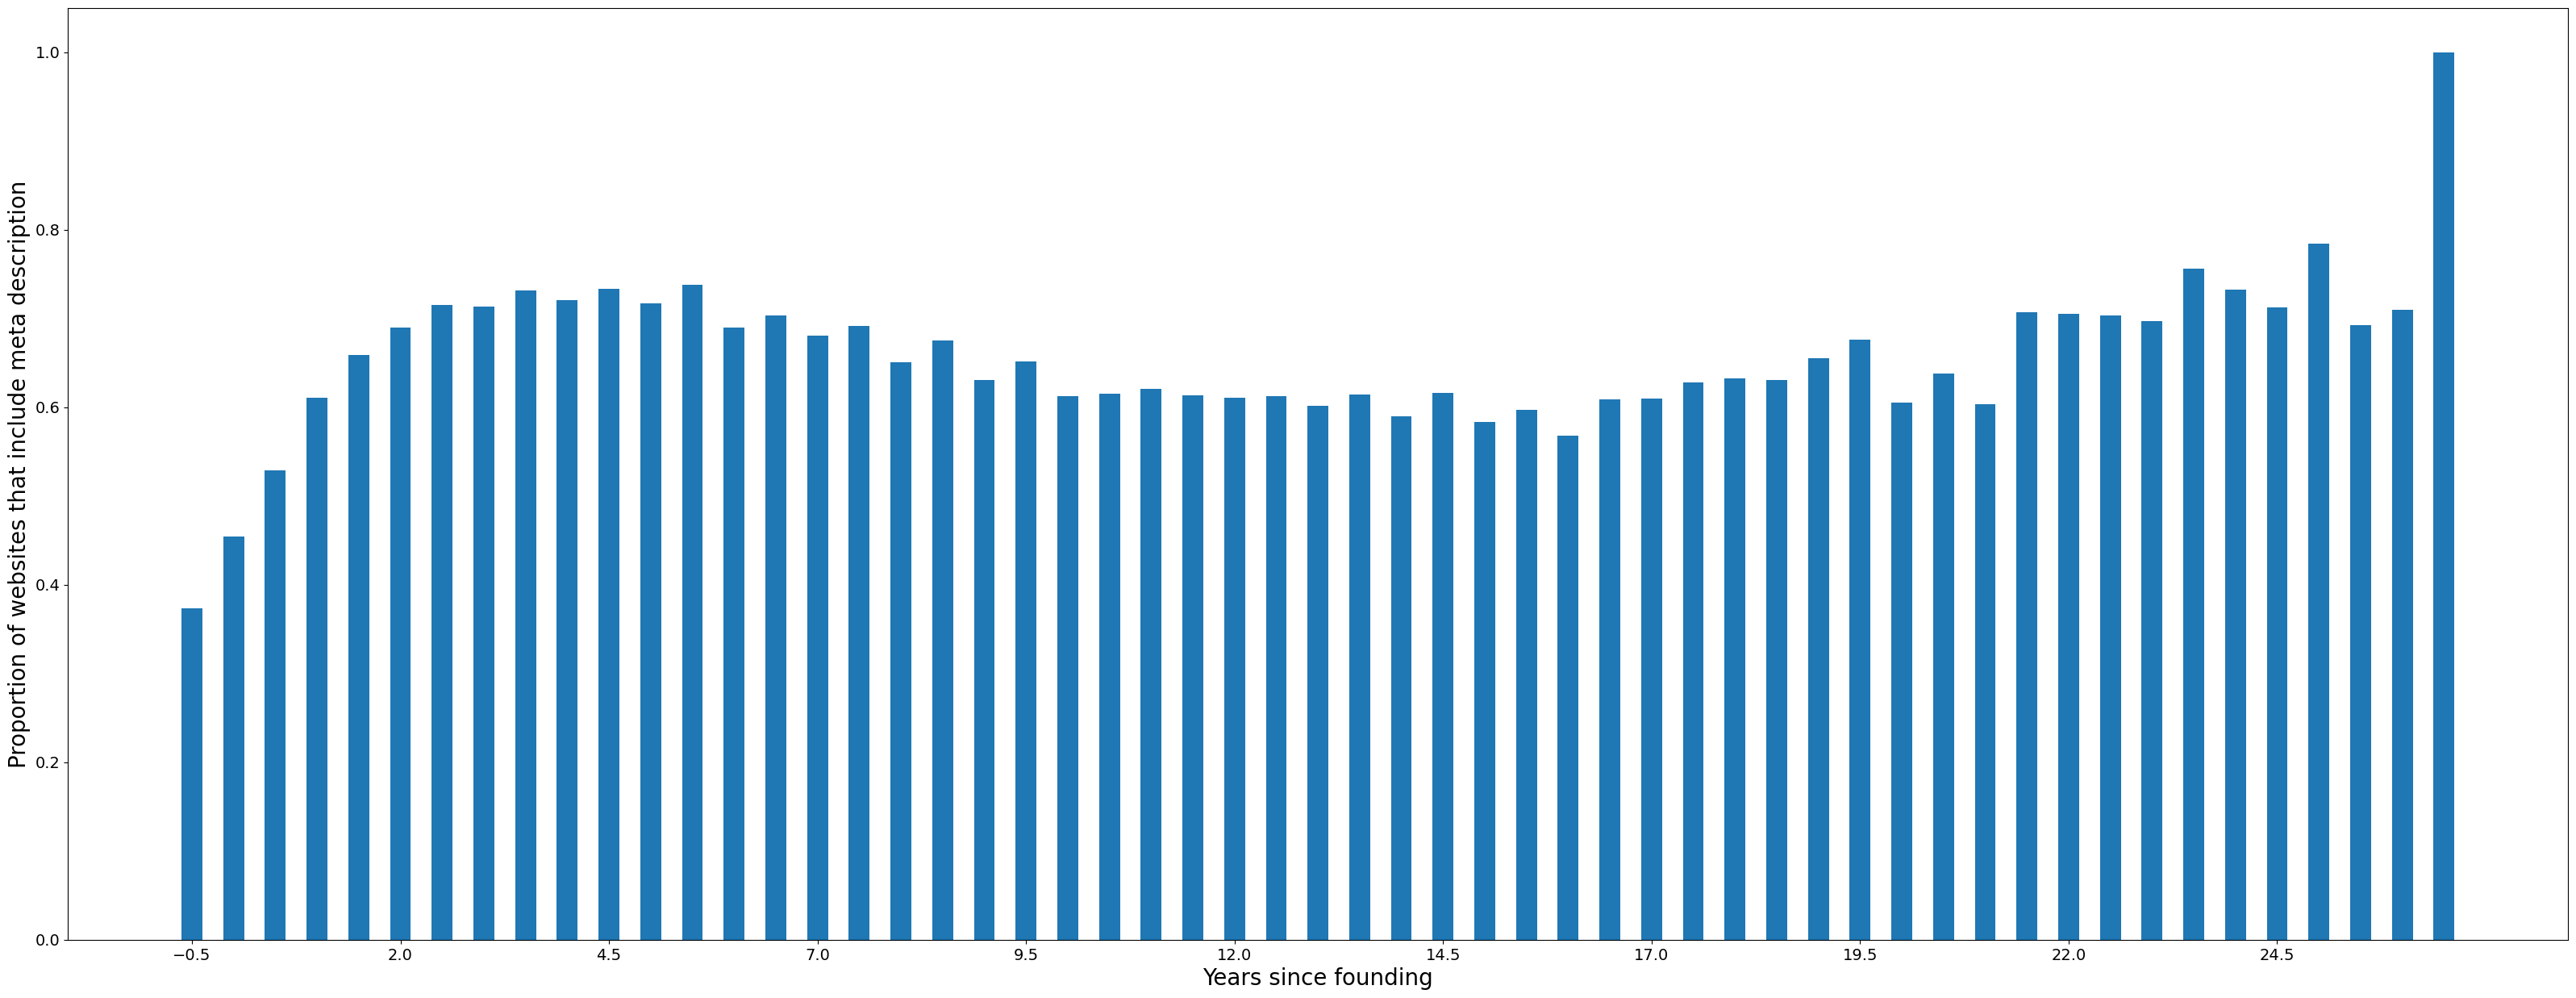

In [70]:
fig, axs = plt.subplots(figsize=(40, 15))
grouped_data = html_data.groupby(html_data["tfs_y"])["meta_description"].mean()
plt.bar(grouped_data.index, grouped_data, width=0.25)
plt.xticks(grouped_data.index[::5], fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Years since founding", fontsize=20);
plt.ylabel("Proportion of websites that include meta description", fontsize=20);

### 5.2 Keywords

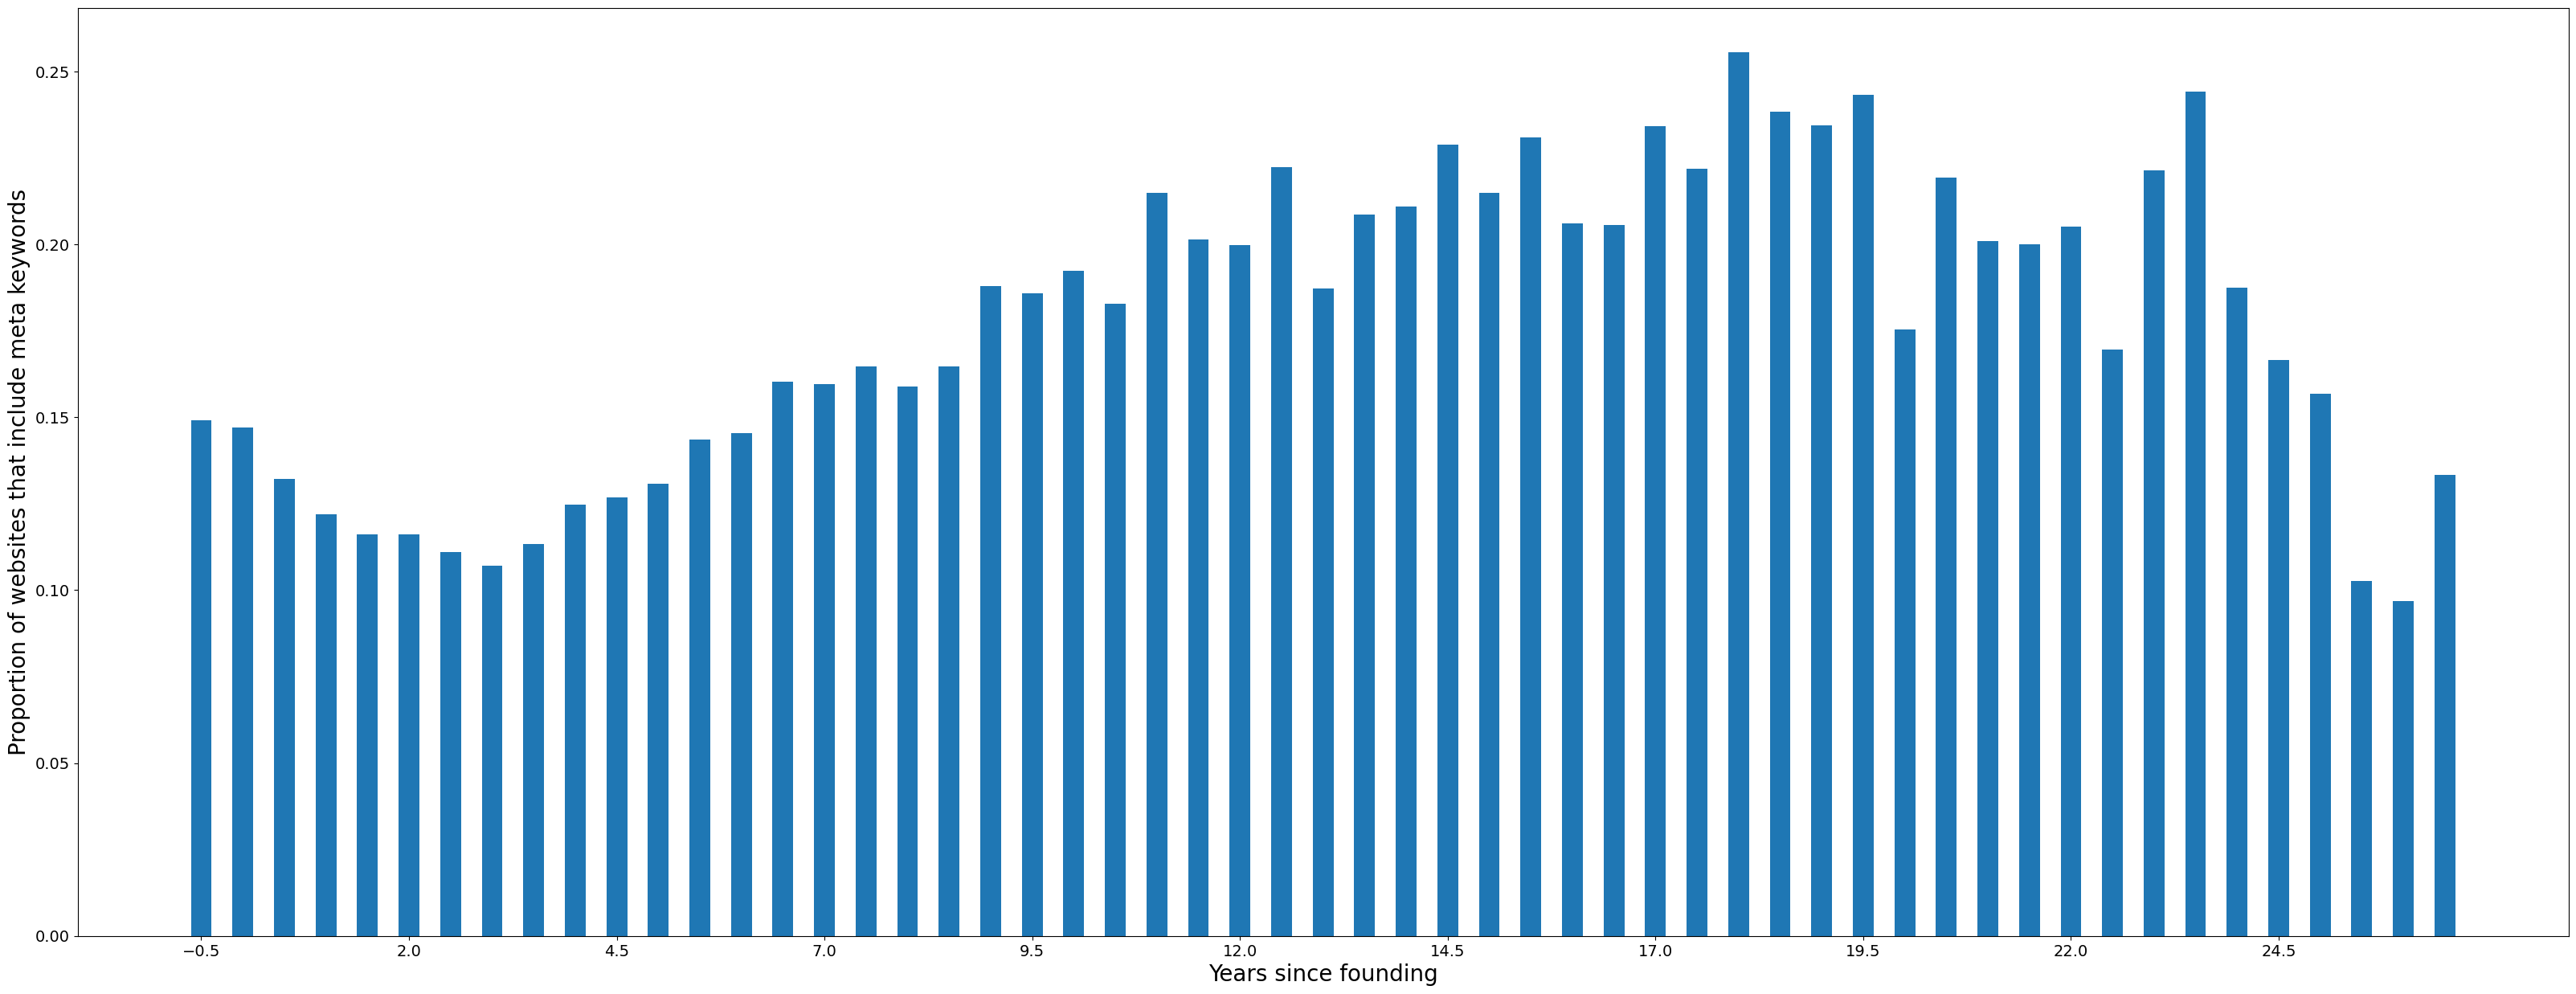

In [71]:
fig, axs = plt.subplots(figsize=(40, 15))
grouped_data = html_data.groupby(html_data["tfs_y"])["meta_keywords"].mean()
plt.bar(grouped_data.index, grouped_data, width=0.25)
plt.xticks(grouped_data.index[::5], fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Years since founding", fontsize=20);
plt.ylabel("Proportion of websites that include meta keywords", fontsize=20);

### 5.3 Description Over Capture Year

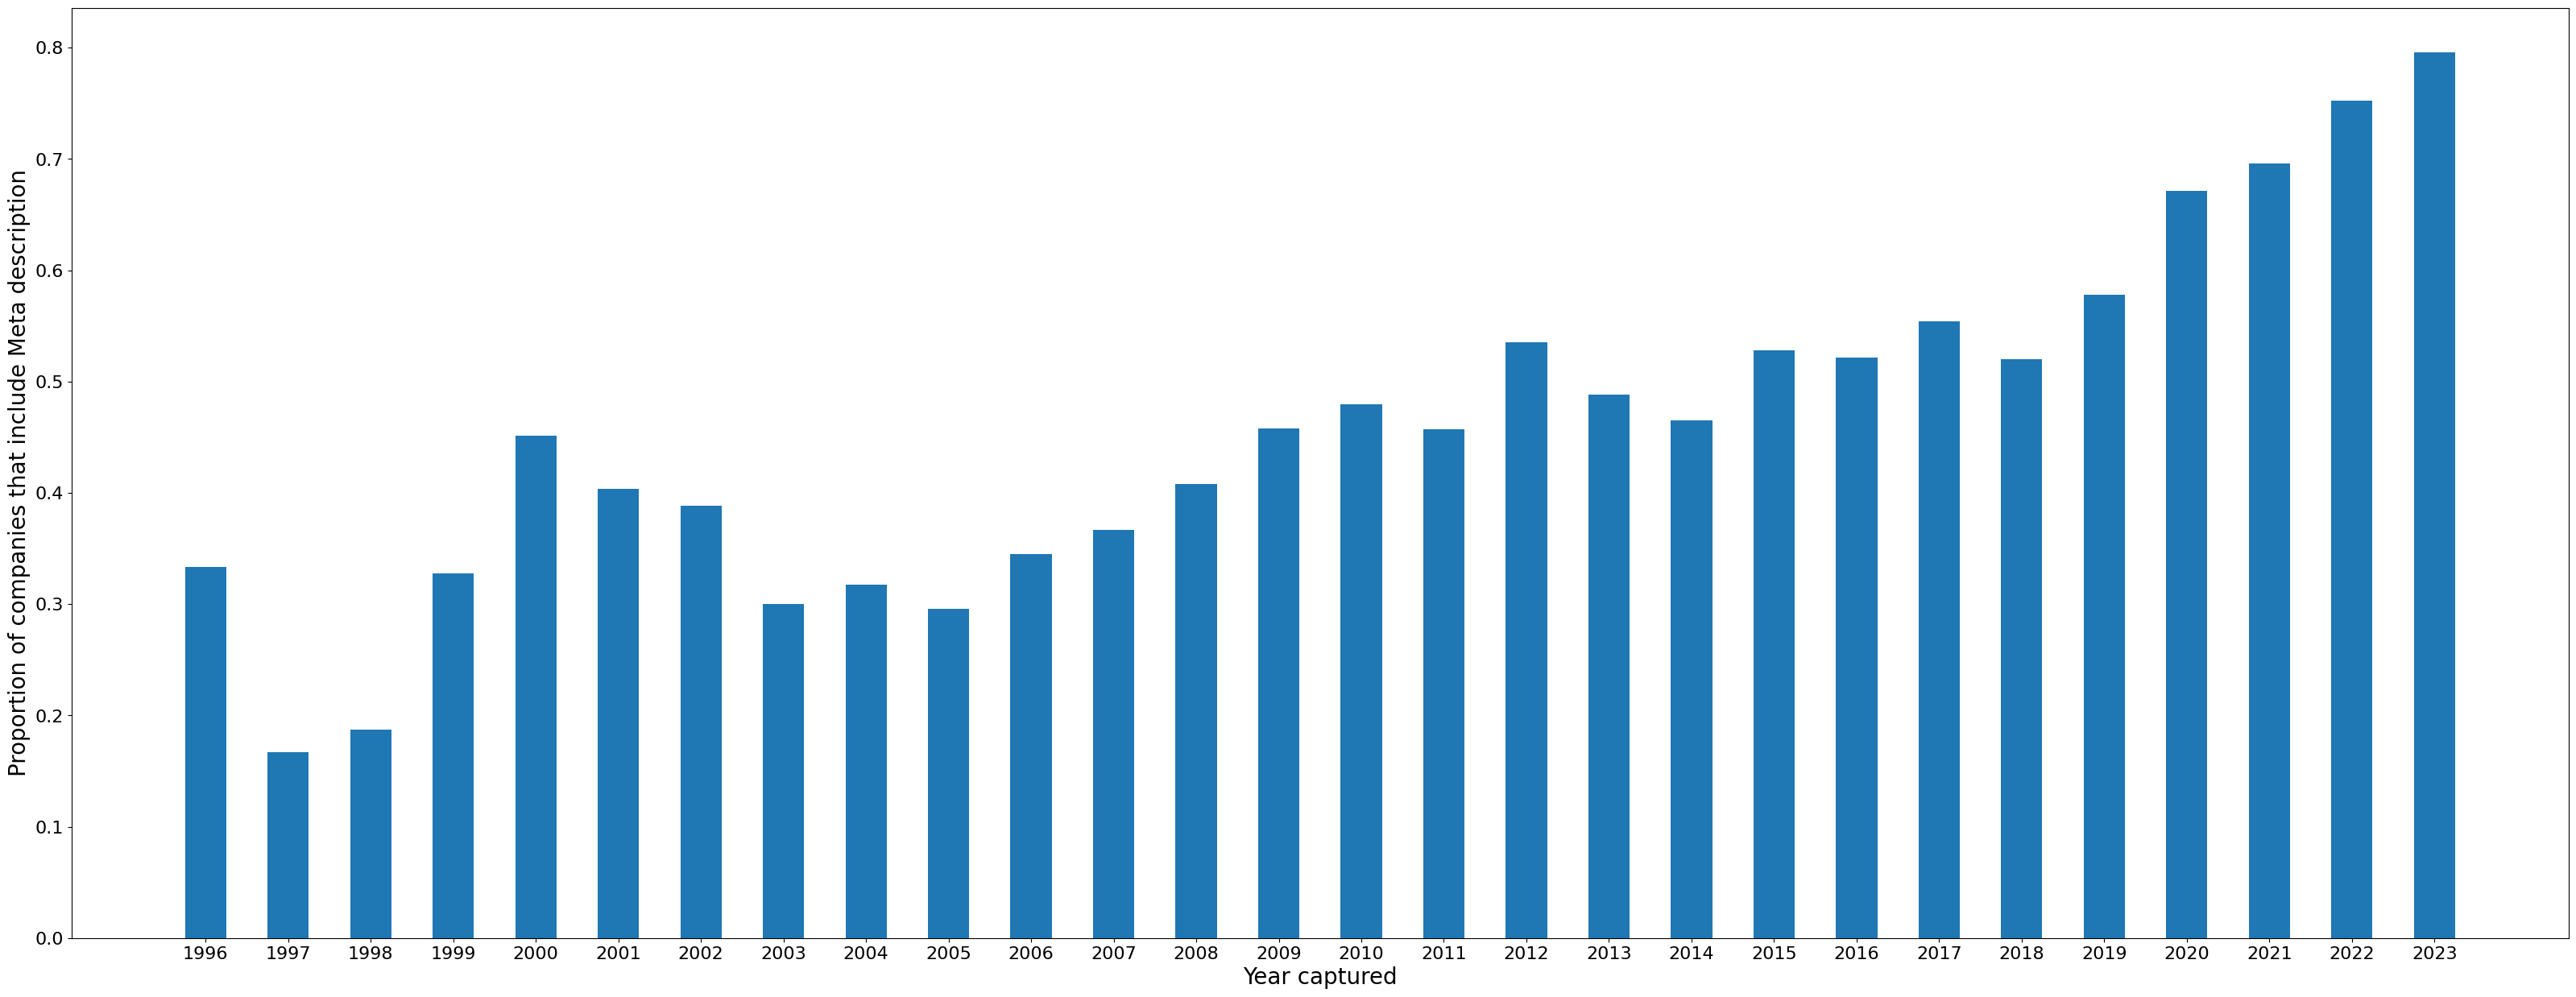

In [72]:
fig, axs = plt.subplots(figsize=(40, 15))
grouped_data = html_data.groupby(html_data["capture_yr"])["meta_description"].mean()
plt.bar(grouped_data.index, grouped_data, width=0.5)
plt.xticks(grouped_data.index, fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Year captured", fontsize=20);
plt.ylabel("Proportion of companies that include Meta description", fontsize=20);

### 5.3 Keywords Over Capture Year

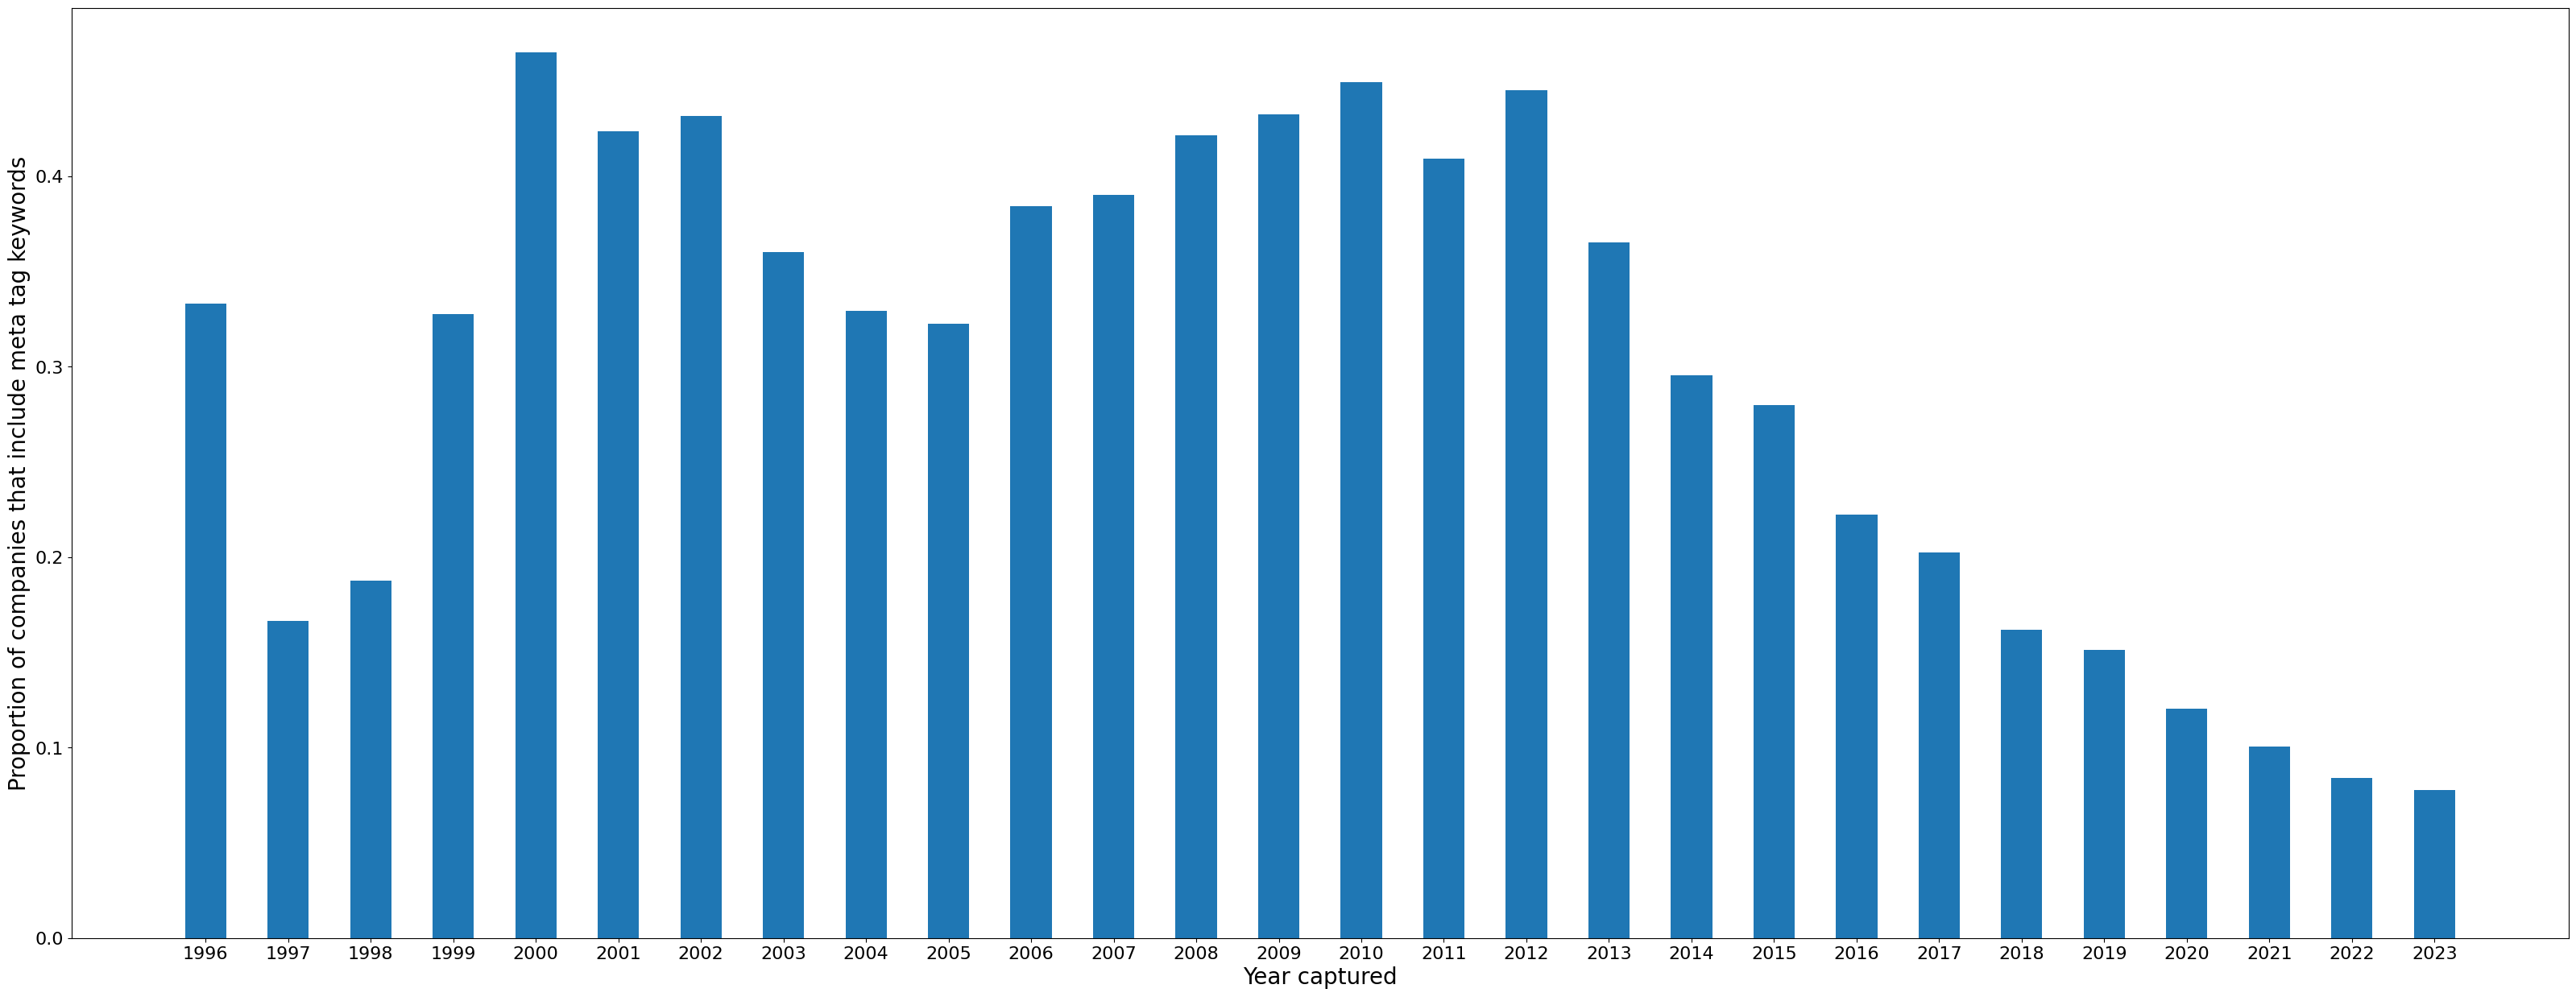

In [73]:
fig, axs = plt.subplots(figsize=(40, 15))
grouped_data = html_data.groupby(html_data["capture_yr"])["meta_keywords"].mean()
plt.bar(grouped_data.index, grouped_data, width=0.5)
plt.xticks(grouped_data.index, fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Year captured", fontsize=20);
plt.ylabel("Proportion of companies that include meta tag keywords", fontsize=20);

## 6. Does `<a>`'s `innertext` include the words "job" or "careers"

Create function that creates new column

In [74]:
def find_job_page(x):
    x = ast.literal_eval(x)
    for word in x:
        if word.lower() in ["job", "jobs", "careers", "career"]:
            return True
    return False

In [75]:
html_data["job_link"] = html_data["a_innertext"].apply(find_job_page)

In [76]:
html_data["job_link"].value_counts()

False    87337
True     29444
Name: job_link, dtype: int64

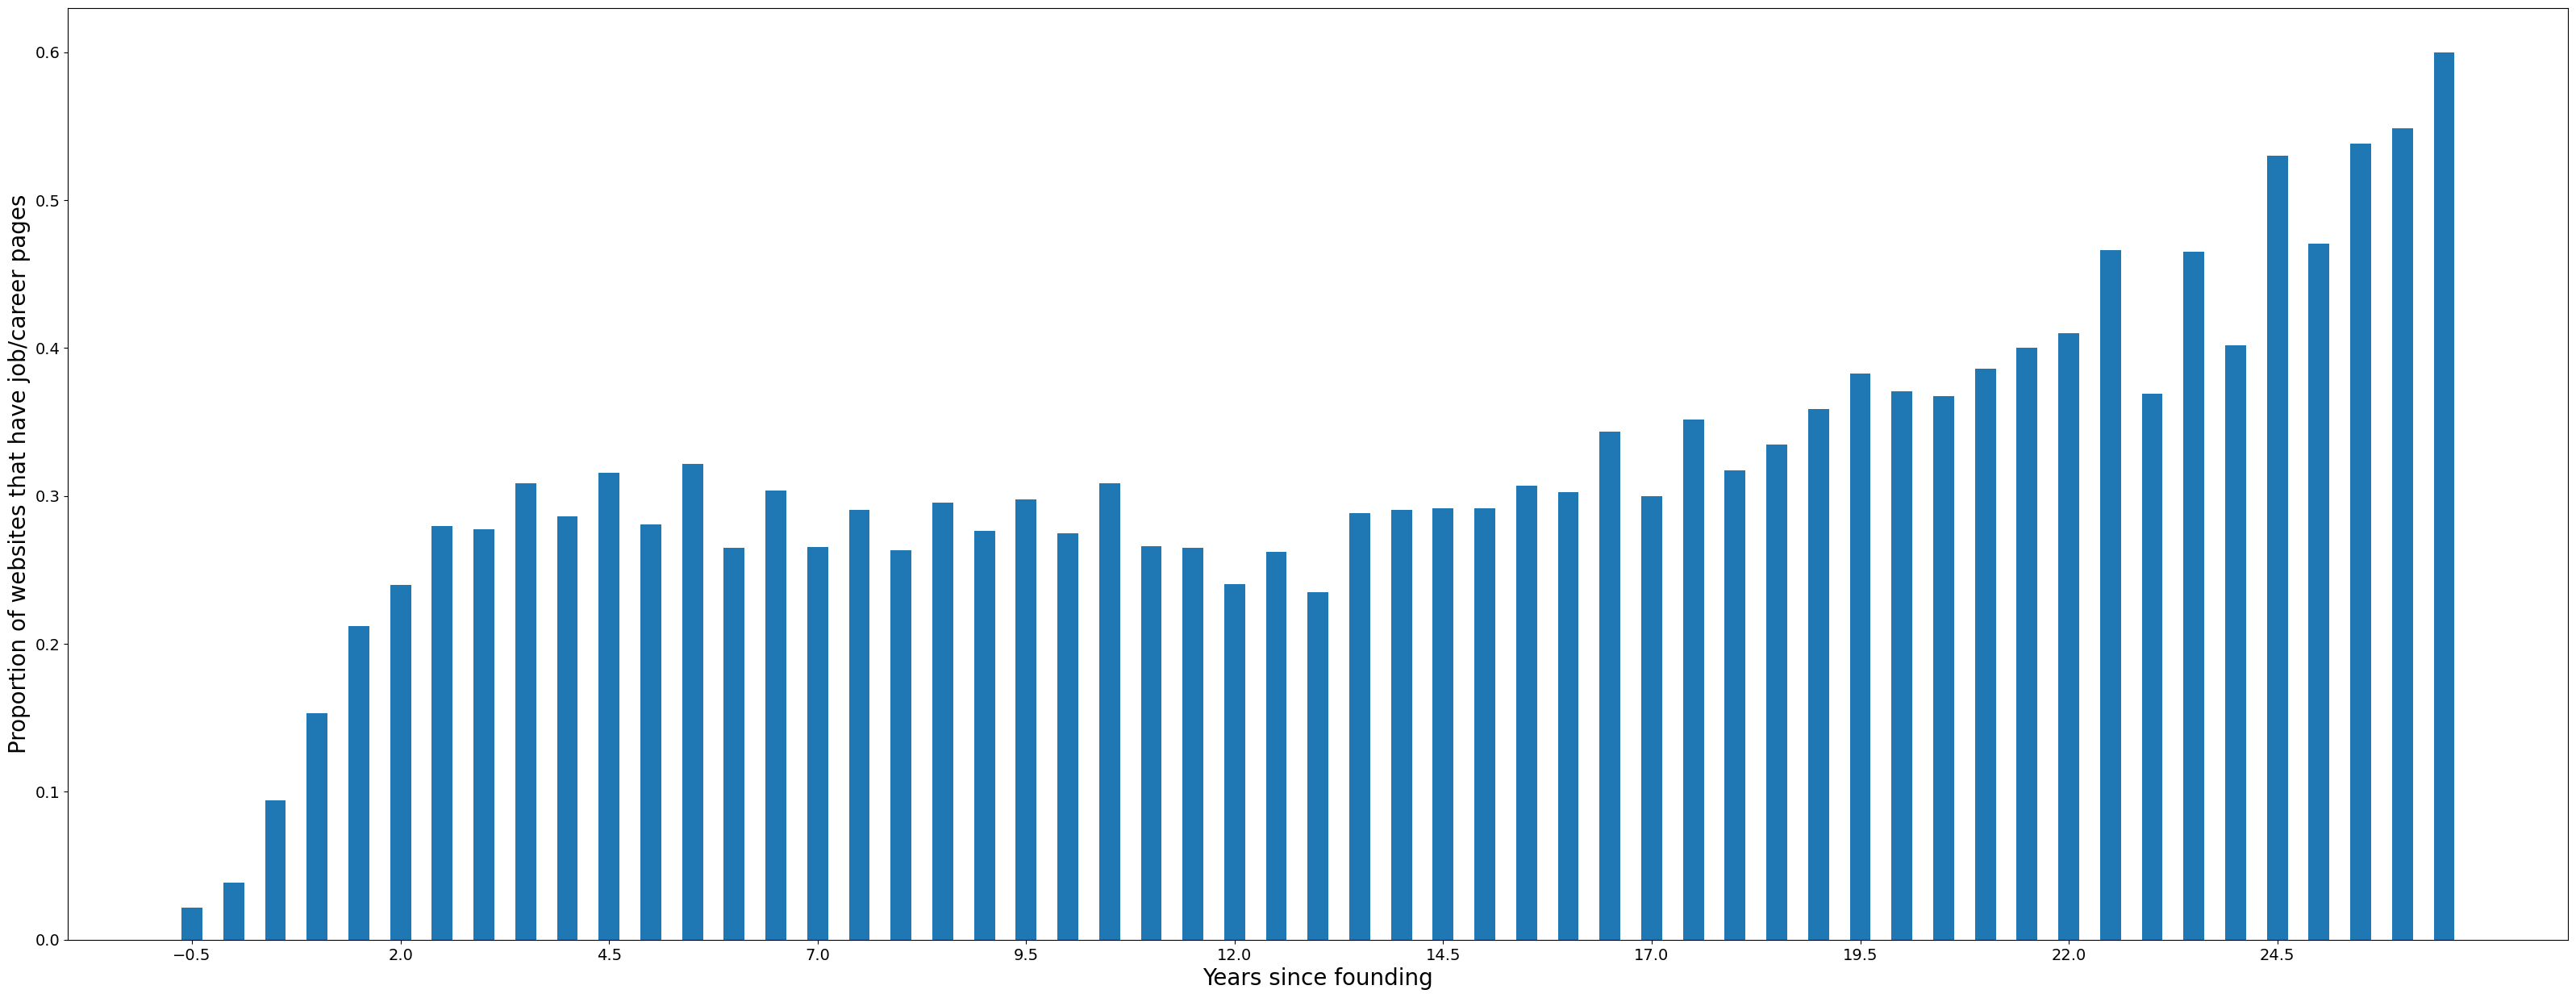

In [77]:
fig, axs = plt.subplots(figsize=(40, 15))
grouped_data = html_data.groupby(html_data["tfs_y"])["job_link"].mean()
plt.bar(grouped_data.index, grouped_data, width=0.25)
plt.xticks(grouped_data.index[::5], fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Years since founding", fontsize=20);
plt.ylabel("Proportion of websites that have job/career pages", fontsize=20);

### 6.1 For companies that got their first their first timestamp within 0-2 years of the founding date?

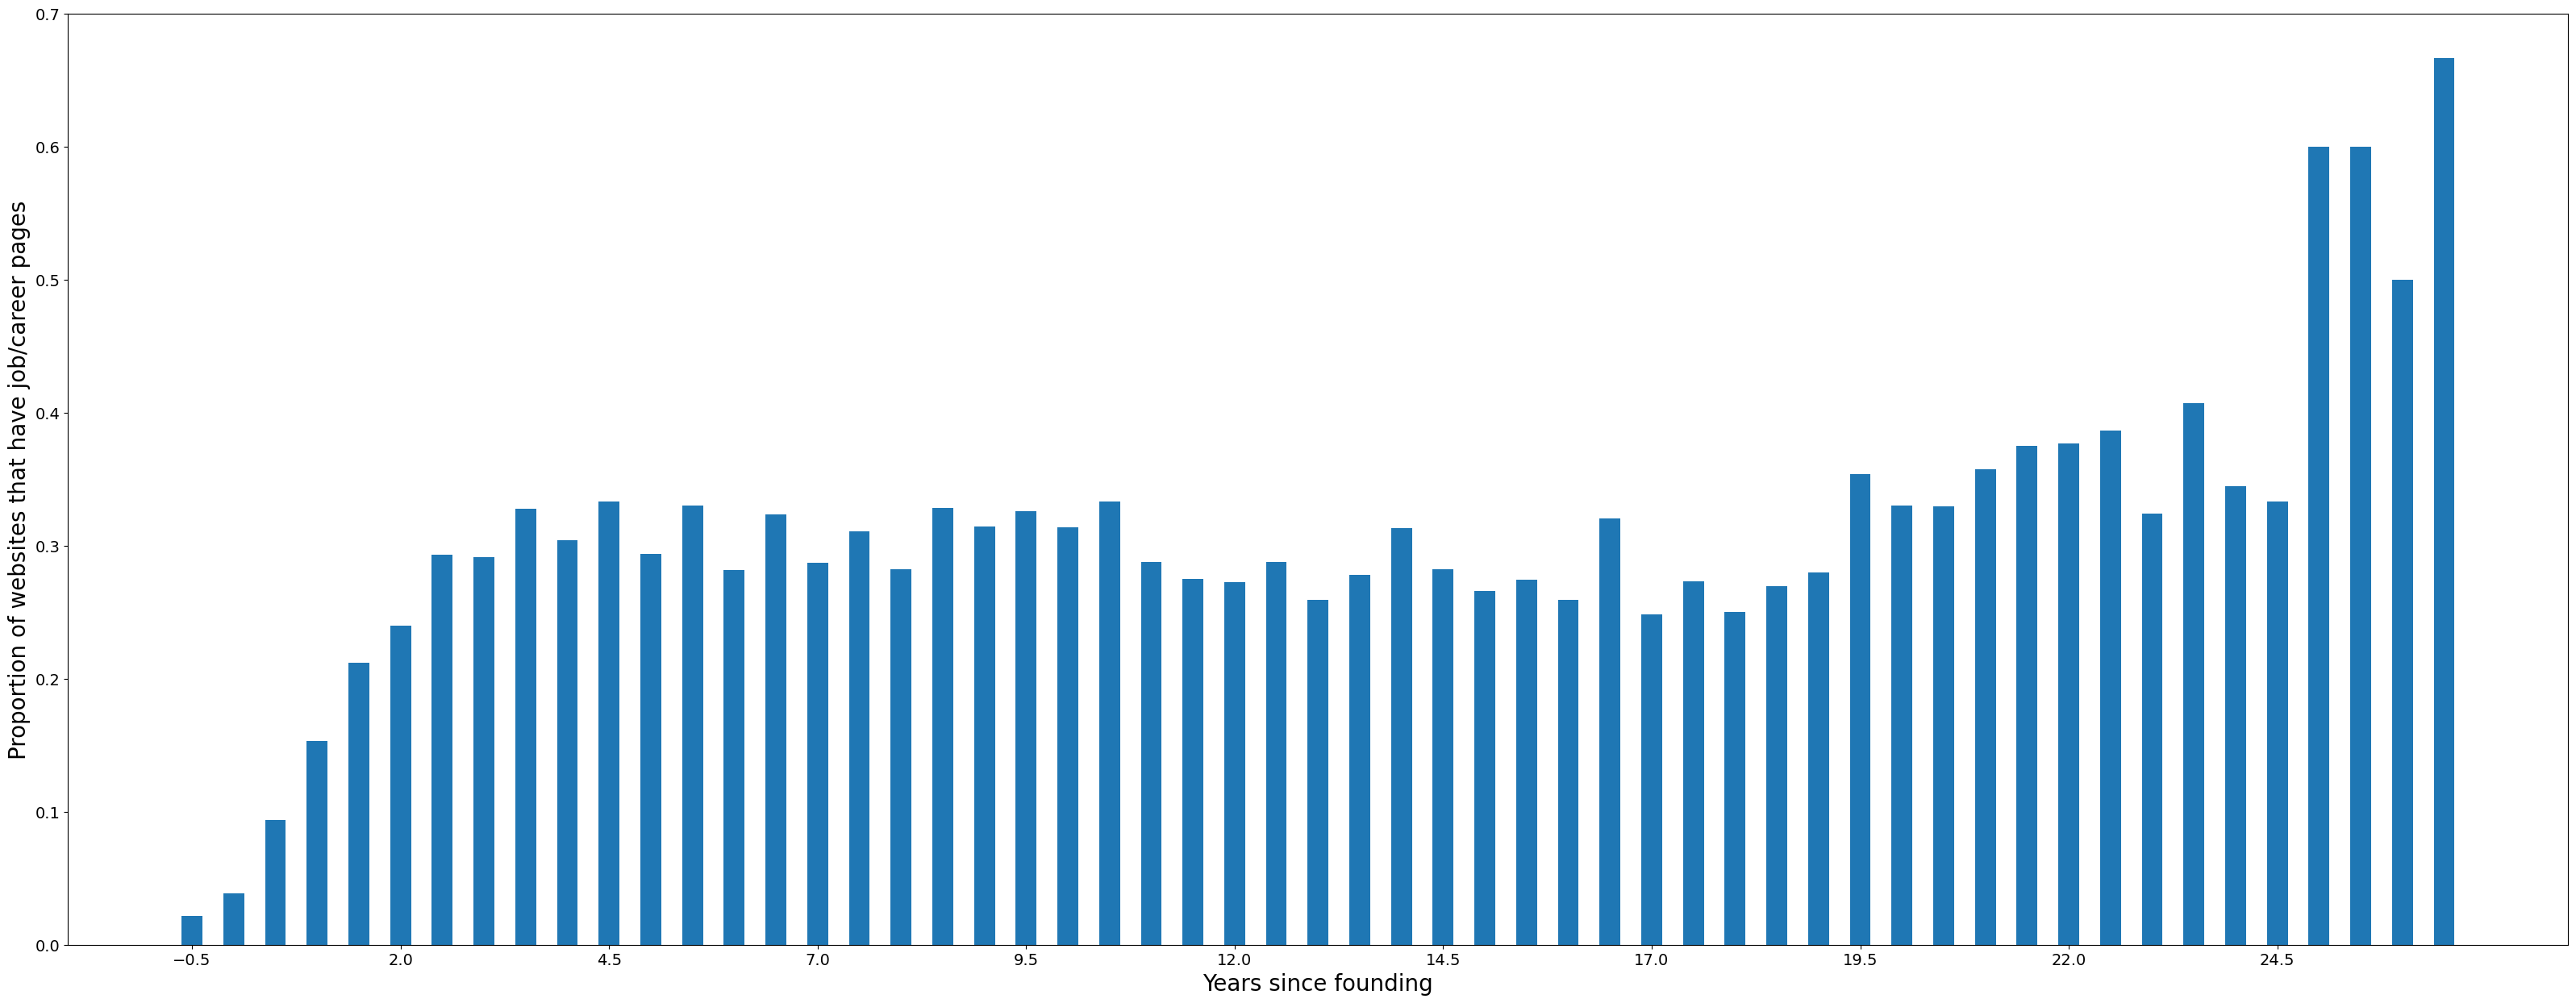

In [78]:
fig, axs = plt.subplots(figsize=(40, 15))
html_subset = html_data[html_data['ft_in_2']]
grouped_data = html_subset.groupby(html_subset["tfs_y"])["job_link"].mean()
plt.bar(grouped_data.index, grouped_data, width=0.25)
plt.xticks(grouped_data.index[::5], fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Years since founding", fontsize=20);
plt.ylabel("Proportion of websites that have job/career pages", fontsize=20);

Numbers are a lot higher towards the end...

### 6.2 Over year captured?

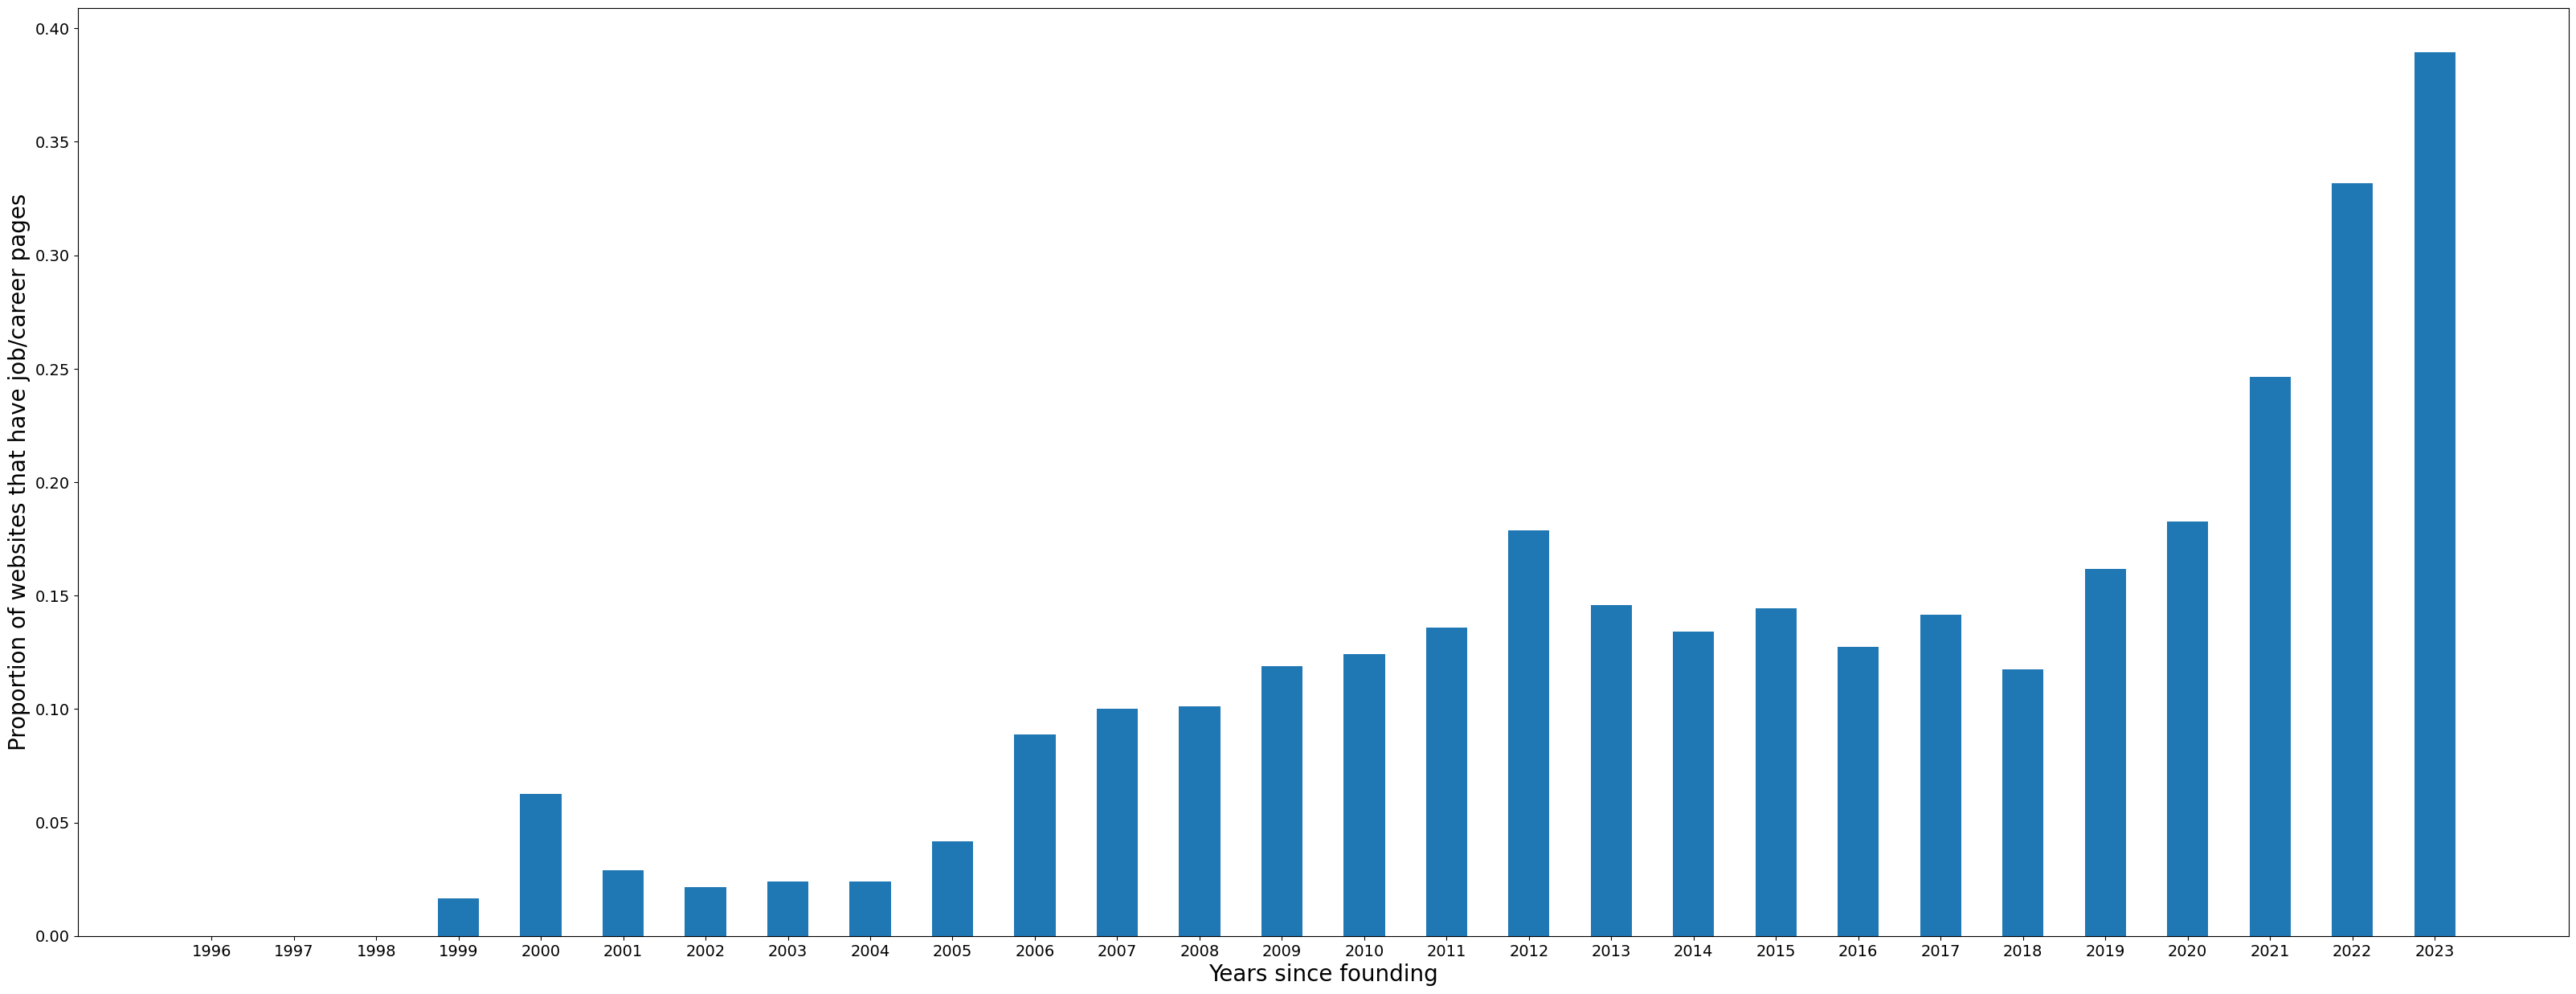

In [79]:
fig, axs = plt.subplots(figsize=(40, 15))
grouped_data = html_data.groupby(html_data["capture_yr"])["job_link"].mean()
plt.bar(grouped_data.index, grouped_data, width=0.5)
plt.xticks(grouped_data.index, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Years since founding", fontsize=20);
plt.ylabel("Proportion of websites that have job/career pages", fontsize=20);

_After_ 2010, we can use this as a signal

### 6.3 Companies founded after 2010?

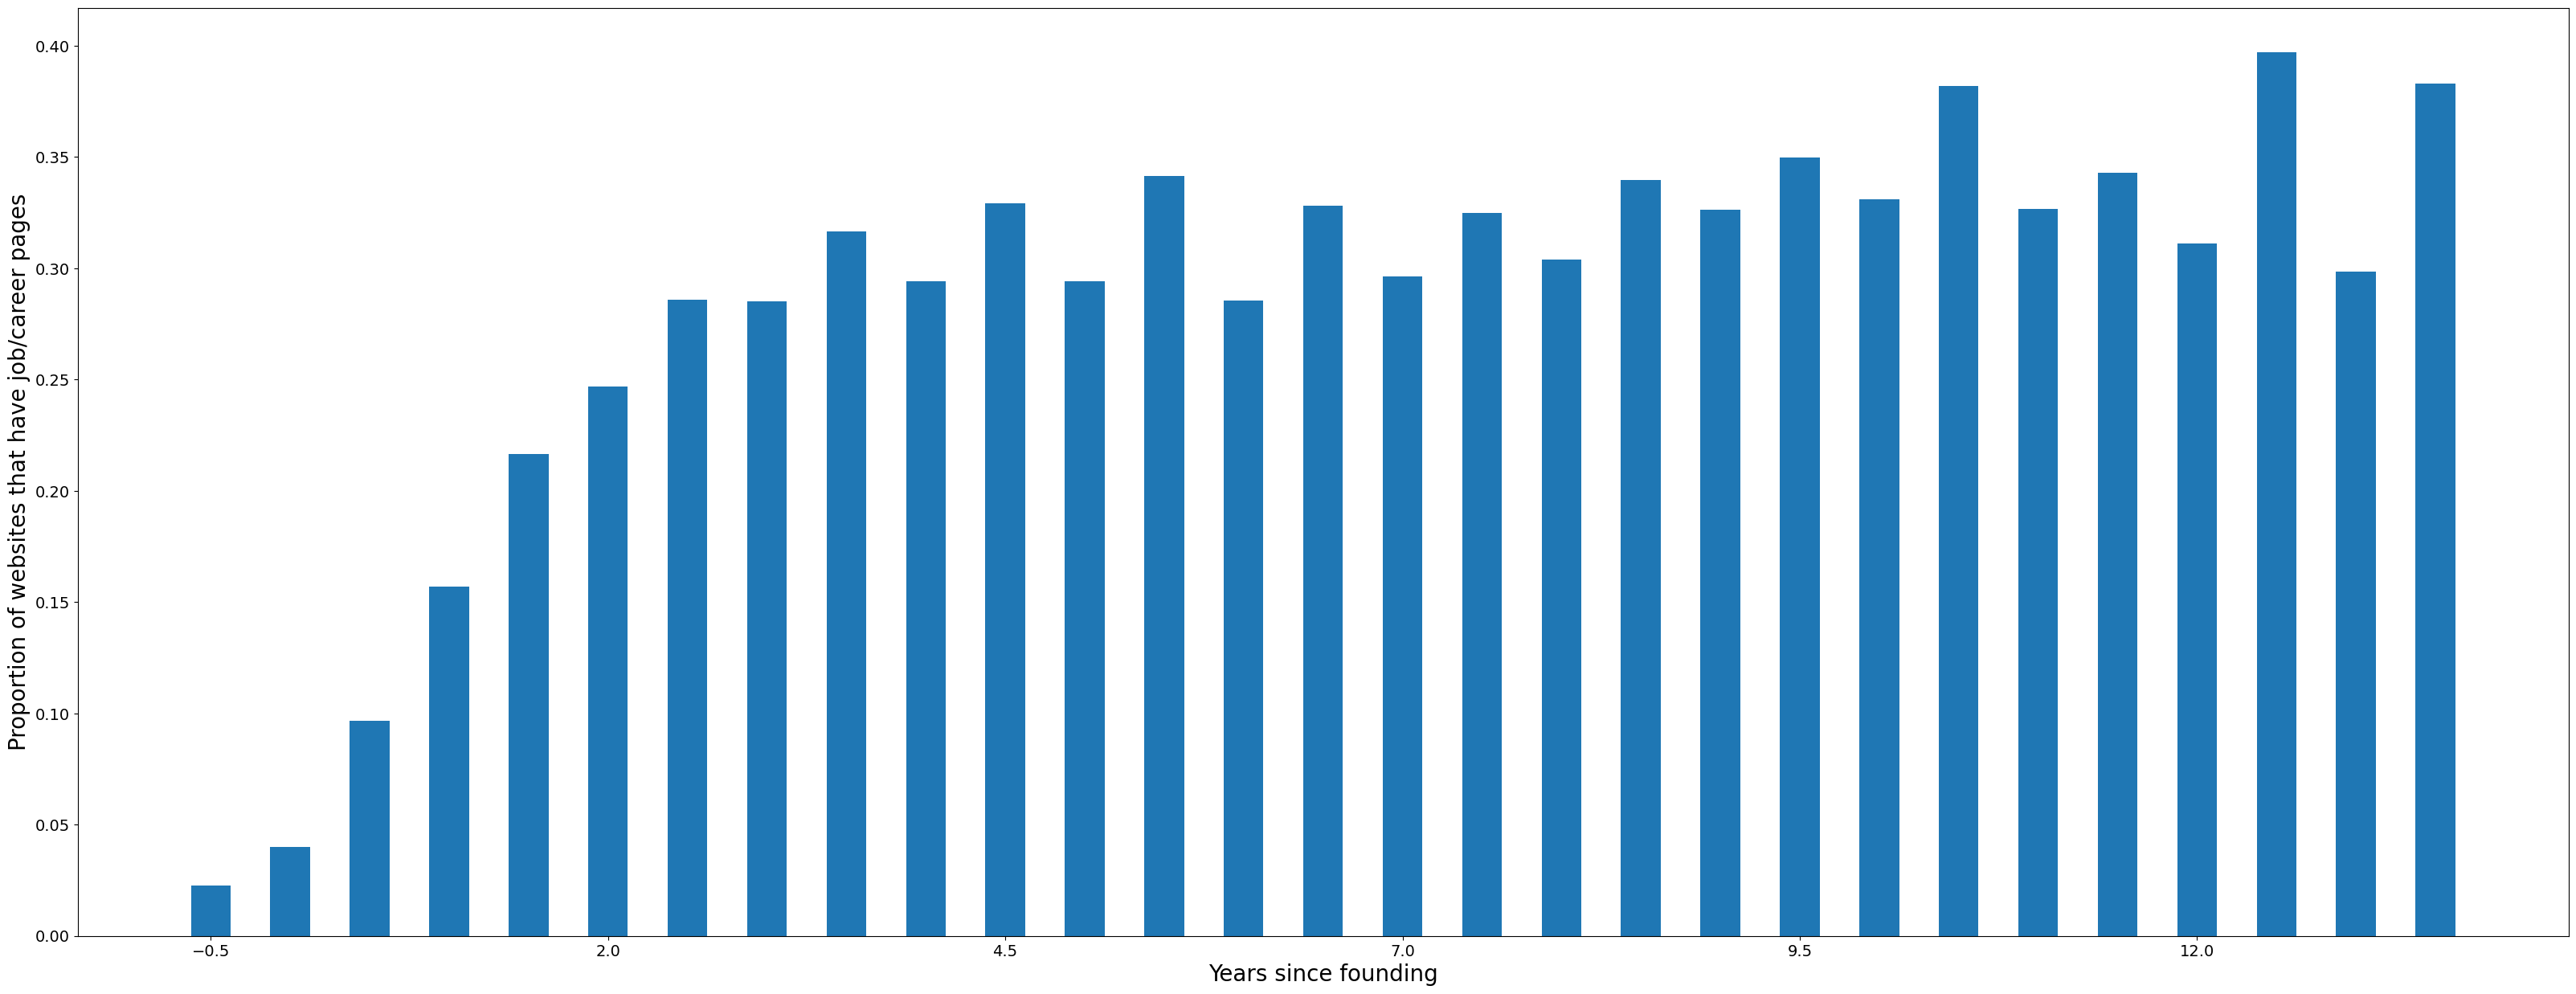

In [80]:
fig, axs = plt.subplots(figsize=(40, 15))
html_d_subset = html_data[html_data["founded_yr"] >= 2010]
grouped_data = html_d_subset.groupby(html_d_subset["tfs_y"])["job_link"].mean()
plt.bar(grouped_data.index, grouped_data, width=0.25)
plt.xticks(grouped_data.index[::5], fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Years since founding", fontsize=20);
plt.ylabel("Proportion of websites that have job/career pages", fontsize=20);